# 引言

<b>研究目的：</b>

本文参考国泰君安研报《探索交易公开信息之市场观察篇》，该研报将交易公开信息以披露原因以及机构席位两种角度进行风格观察以及收益分析，观察不同披露原因下以及不同情况的机构席位下信息被公开的股票在A股市场中超额收益的表现。

<b>交易公开信息介绍：</b>  

交易公开信息，也就是我们通常所说的“龙虎榜”，是指交易所每日公开披露的，满足一定条件的个股交易数据，包括其当日买入、卖出金额最大的五家会员营业部的名称及其买入、卖出金额。本文主要分析的为涨幅或跌幅偏离值达7%的证券，日价格振幅达到15%的证券，换手率达20%的证券，连续三个交易日内收盘价格涨幅或跌幅偏离值累计达到20%的证券，以及有机构参与买入的证券。

<b>研究思路：</b>

（1）选择标的A股指数及时间段，并从JQData中筛选龙虎榜包含在标的指数的数据。

（2）根据不同研究对象对数据进行分类。

（3）对于每种研究对象，观察其风格：包括行业分布及板块分布。

（4）对于每种研究对象，计算从上榜日起至上榜60天后相对标的指数的超额收益。

<b>研究指数：</b>

000985.XSHG

<b>研究时间：</b>

2011.08 - 2015.02

<b>研究环境：</b>

python 3

# 初始化设置

## 设定指数，时间区间及不同股票池

In [1]:
from jqdata import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
A_stock_list = get_index_stocks('000985.XSHG', date=None)
billboard = get_billboard_list(stock_list = A_stock_list, start_date = '2011-08-02', end_date = '2015-02-01')

In [7]:
billboard_increase = billboard[billboard['abnormal_name'] == '涨幅偏离值达7%的证券']

billboard_decrease = billboard[billboard['abnormal_name'] == '跌幅偏离值达7%的证券']

billboard_amplitude = billboard[billboard['abnormal_name'] == '日价格振幅达到15%的证券']

billboard_turnover = billboard[billboard['abnormal_name'] == '换手率达20%的证券']

billboard_increase_series = billboard[billboard['abnormal_name'] == '连续三个交易日内收盘价格涨幅偏离值累计达到20%的证券']

billboard_decrease_series = billboard[billboard['abnormal_name'] == '连续三个交易日内收盘价格跌幅偏离值累计达到20%的证券']

In [3]:
billboard_buy = billboard[billboard['direction'] == 'BUY']

In [9]:
billboard_org = billboard_buy[billboard_buy['sales_depart_name'] == '机构专用']

## 定义相关函数

定义行业分布观察及可视化函数 

In [35]:
def get_industry_code_from_security(security,date=None):
    industry_index=get_industries(name='sw_l1').index
    for i in range(0,len(industry_index)):
        try:
            index = get_industry_stocks(industry_index[i],date=date).index(security)
            return industry_index[i]
        except:
            continue
    return u'未找到'

In [36]:
def industry_count(data_df):
    date_list = list(data_df['day'])
    day_list = list(set(date_list))
    industry_df = get_industries(name='sw_l1')
    industry = list(industry_df['name'])
    industry_value = list(zeros(len(industry)))
    industries_df = pd.DataFrame(industry_value, index = industry)
    for day in day_list:
        daily_stock = data_df[data_df['day'] == day]
        stock_list = list(daily_stock['code'])
        code_list = list(set(stock_list))
        for code in code_list:
            code_industry = get_industry_code_from_security(code)
            if code_industry != '未找到':
                code_industry = industry_df.loc[code_industry,'name']
                for item in industry:
                    if code_industry == item:
                        industries_df.loc[item,0] = industries_df.loc[item,0] + 1
            else:
                pass
    summation = sum(industries_df)[0]
    industries_df = industries_df / summation
    return industries_df

In [37]:
def benchmark_rate_calculation(stock_list):
    industry_df = get_industries(name='sw_l1')
    industry = list(industry_df['name'])
    industry_value = list(zeros(len(industry)))
    industries_df = pd.DataFrame(industry_value, index = industry)
    for code in stock_list:
        code_industry = get_industry_code_from_security(code)
        if code_industry != '未找到':
            code_industry = industry_df.loc[code_industry,'name']
            for item in industry:
                if code_industry == item:
                    industries_df.loc[item,0] = industries_df.loc[item,0] + 1
        else:
            pass
    summation = sum(industries_df)[0]
    industries_df = industries_df / summation
    return industries_df

In [38]:
def industry_plot(benchmark, industry_count_df):
    industry_df = industry_count_df - benchmark
    industry_df = industry_df.sort_values(by = 0,ascending = False)
    industry_df.plot(kind = 'bar',figsize = (24,12))

定义板块分布与数量观察及可视化函数

In [10]:
def part_belonged(data_df):
    date_list = list(data_df['day'])
    day_list = []
    day_list.append(date_list[0])
    for item in date_list:
            if item not in day_list:
                day_list.append(item)
    length = len(day_list) - 1
    range_length = range(0,length)
    daily_list = []
    for number in range_length:
        daily_list.append(day_list[length - number])
    part_df = pd.DataFrame() 
    for day in daily_list:
        daily_stock = data_df[data_df['day'] == day]
        stock_list = list(daily_stock['code'])
        code_list = list(set(stock_list))
        MAIN = 0
        SME = 0
        GEM = 0
        for code in code_list:
            if (code[:3] in ['000', '600', '603', '601']) or (code[:3] in ['001696', '001896', '001979', '001965']):
                MAIN = MAIN + 1
            elif code[:3] == '002':
                SME = SME + 1
            elif code[:3] == '300':
                GEM = GEM + 1
        summation = MAIN + SME + GEM
        part_daily = [MAIN / summation, SME / summation, GEM / summation, summation]
        part_df[day] = part_daily
    return part_df

In [11]:
def monthly_part(data_df):
    year_list = [2011, 2012, 2013, 2014, 2015]
    month_list = list(range(1,13))
    index_list = list(data_df.columns)
    year_month_df = pd.DataFrame()
    for year in year_list:
        for month in month_list:
            column_name = str(year) + str(month)
            column = [0, 0, 0, 0]
            for index in index_list:
                if index.year == year and index.month == month:
                    rows = [0, 1, 2, 3]
                    for number in rows:
                        column[number] = column[number] + data_df[index][number]
            if column[0] != 0 or column[1] != 0 or column[2] != 0:
                summation = column[0] + column[1] + column[2]
                for number in [0, 1, 2]:
                    column[number] = column[number] / summation
                year_month_df[column_name] = column
    return year_month_df

定义披露原因超额收益计算及可视化函数

In [4]:
def price_calculation(data_df):
    billboard = data_df[data_df['direction'] != 'ALL']
    date_list = list(billboard['day'])
    day_list = list(set(date_list))
    day_list.sort(key = date_list.index)
    trade_days = list(get_all_trade_days())
    price_df = pd.DataFrame()
    
    for day in day_list:
        billboard_daily = billboard[billboard['day'] == day]
        code_list = list(set(billboard_daily['code']))
        location = trade_days.index(day)
        
        #获取每日对应期限内基准指数收益率
        benchmark_series = get_price('000985.XSHG', start_date = day, end_date = trade_days[location+60])['close']
        benchmark_list = list(benchmark_series)
        standard_benchmark = benchmark_list[0]
        absolute_benchmark = []
        for benchmark in benchmark_list:
            new_benchmark = benchmark / standard_benchmark
            absolute_benchmark.append(new_benchmark)
        
        #找出无法交易的股票    
        unavailable_list = []
        for code in code_list:
            volume_series = get_price(code, start_date = trade_days[location+1], end_date = trade_days[location+2])['volume']
            volume = volume_series[trade_days[location+1]]
            if volume == 0:
                unavailable_list.append(code)
        
        #剔除无法交易的股票
        available_list = []
        for code in code_list:
            if code not in unavailable_list:
                available_list.append(code)
        
        #对于每只股票计算对应期限超额收益
        for code in available_list:
            name = str(day) + str(',') + str(code)
            price_series = get_price(code, start_date = day, end_date = trade_days[location+60])['close']
            price_list = list(price_series)
            standard_price = price_list[0]
            absolute_price = []
            for price in price_list:
                new_price = price / standard_price
                absolute_price.append(new_price)
            return_list = []
            label = list(range(0,len(price_list)))
            for number in label:
                excess_return = absolute_price[number] - absolute_benchmark[number]
                return_list.append(excess_return)
            price_df[name] = return_list
    return price_df        

In [4]:
def return_plot(data_df):
    price_df = price_calculation(data_df)
    mean_price = mean(price_df, axis = 1)
    plt.figure(figsize=(24, 12))
    plt.plot(mean_price)

定义机构专用席位绝对数量超额收益计算及可视化函数

In [44]:
def depart_count(data_df, number):
    date_list = list(billboard_buy['day'])
    day_list = list(set(date_list))
    day_list.sort(key = date_list.index)
    trade_days = list(get_all_trade_days())
    price_df = pd.DataFrame()
    
    for day in day_list:
        daily_billboard = data_df[data_df['day'] == day]
        billboard_depart = daily_billboard[daily_billboard['sales_depart_name'] == '机构专用']
        location = trade_days.index(day)
        
        benchmark_series = get_price('000985.XSHG', start_date = day, end_date = trade_days[location+60])['close']
        benchmark_list = list(benchmark_series)
        standard_benchmark = benchmark_list[0]
        absolute_benchmark = []
        for benchmark in benchmark_list:
            new_benchmark = benchmark / standard_benchmark
            absolute_benchmark.append(new_benchmark)
         
        #筛选
        stock_list = list(daily_billboard['code'])
        code_list = list(set(stock_list))
        department_list = list(billboard_depart['code'])
        depart_list = list(set(department_list))
        primary_list = []
        for code in depart_list:
            code_summation = billboard_depart[billboard_depart['code'] == code]
            ranking_list = list(code_summation['rank'])
            rank_list = list(set(ranking_list))    
            if len(rank_list) > number:
                primary_list.append(code)
        
        
        unavailable_list = []
        for code in depart_list:
            volume_series = get_price(code, start_date = trade_days[location+1], end_date = trade_days[location+2])['volume']
            volume = volume_series[trade_days[location+1]]
            if volume == 0:
                unavailable_list.append(code)
        
        available_list = []
        for code in primary_list:
            if code not in unavailable_list:
                available_list.append(code)
                
        for code in available_list:
            name = str(day) + str(',') + str(code)
            price_series = get_price(code, start_date = day, end_date = trade_days[location+60])['close']
            price_list = list(price_series)
            standard_price = price_list[0]
            absolute_price = []
            for price in price_list:
                new_price = price / standard_price
                absolute_price.append(new_price)
            return_list = []
            label = list(range(0,len(price_list)))
            for number in label:
                excess_return = absolute_price[number] - absolute_benchmark[number]
                return_list.append(excess_return)
            price_df[name] = return_list
    return price_df        

In [45]:
def count_mean_price(data_df,numbers):
    mean_price_df = pd.DataFrame()
    primary_mean_price = price_calculation(data_df)
    mean_price_df['-1'] = mean(primary_mean_price, axis = 1)
    for number in numbers:
        price_df = depart_count(data_df,number)
        mean_price = mean(price_df, axis = 1)
        mean_price_df[number] = mean_price
    return mean_price_df

定义机构专用席位金额占比超额收益计算及可视化函数

In [5]:
def depart_rate(data_df, rate):
    date_list = list(billboard_buy['day'])
    day_list = list(set(date_list))
    day_list.sort(key = date_list.index)
    trade_days = list(get_all_trade_days())
    price_df = pd.DataFrame()
    
    for day in day_list:
        daily_billboard = data_df[data_df['day'] == day]
        billboard_depart = daily_billboard[daily_billboard['sales_depart_name'] == '机构专用']
        location = trade_days.index(day)
        
        #基准
        benchmark_series = get_price('000985.XSHG', start_date = day, end_date = trade_days[location+60])['close']
        benchmark_list = list(benchmark_series)
        standard_benchmark = benchmark_list[0]
        absolute_benchmark = []
        for benchmark in benchmark_list:
            new_benchmark = benchmark / standard_benchmark
            absolute_benchmark.append(new_benchmark)
        
        #股票筛选
        stock_list = list(daily_billboard['code'])
        code_list = list(set(stock_list))
        department_list = list(billboard_depart['code'])
        depart_list = list(set(department_list))
        primary_list = []
        for code in depart_list:
            code_summation = billboard_depart[billboard_depart['code'] == code]
            summation = 0
            ranking_list = list(code_summation['rank'])
            rank_list = list(set(ranking_list))
            for rank in rank_list:
                rank_mean = code_summation[code_summation['rank'] == rank]
                mean_rank = sum(list(rank_mean['buy_rate'])) / len(list(rank_mean['buy_rate']))
                summation = summation + mean_rank
            if summation > rate:
                primary_list.append(code)
        
        #取消不能交易
        unavailable_list = []
        for code in depart_list:
            volume_series = get_price(code, start_date = trade_days[location+1], end_date = trade_days[location+2])['volume']
            volume = volume_series[trade_days[location+1]]
            if volume == 0:
                unavailable_list.append(code)
        
        #剩余股票
        available_list = []
        for code in primary_list:
            if code not in unavailable_list:
                available_list.append(code)
        
        for code in available_list:
            name = str(day) + str(',') + str(code)
            price_series = get_price(code, start_date = day, end_date = trade_days[location+60])['close']
            price_list = list(price_series)
            standard_price = price_list[0]
            absolute_price = []
            for price in price_list:
                new_price = price / standard_price
                absolute_price.append(new_price)
            return_list = []
            label = list(range(0,len(price_list)))
            for number in label:
                excess_return = absolute_price[number] - absolute_benchmark[number]
                return_list.append(excess_return)
            price_df[name] = return_list
    return price_df        

In [6]:
def rate_mean_price(data_df,numbers):
    mean_price_df = pd.DataFrame()
    primary_mean_price = price_calculation(data_df)
    mean_price_df['-1'] = mean(primary_mean_price, axis = 1)
    for number in numbers:
        price_df = depart_rate(data_df,number)
        mean_price = mean(price_df, axis = 1)
        mean_price_df[number] = mean_price
    return mean_price_df

# 风格观察 — 从披露原因的视角

设定基准行业分布比例

In [41]:
benchmark = benchmark_rate_calculation(A_stock_list)

## 涨幅偏离值达7%的证券

In [12]:
part_increase = part_belonged(billboard_increase)
monthly_part_increase = monthly_part(part_increase)
bar_increase = monthly_part_increase.loc[:2].T
sum_increase = monthly_part_increase.loc[3]

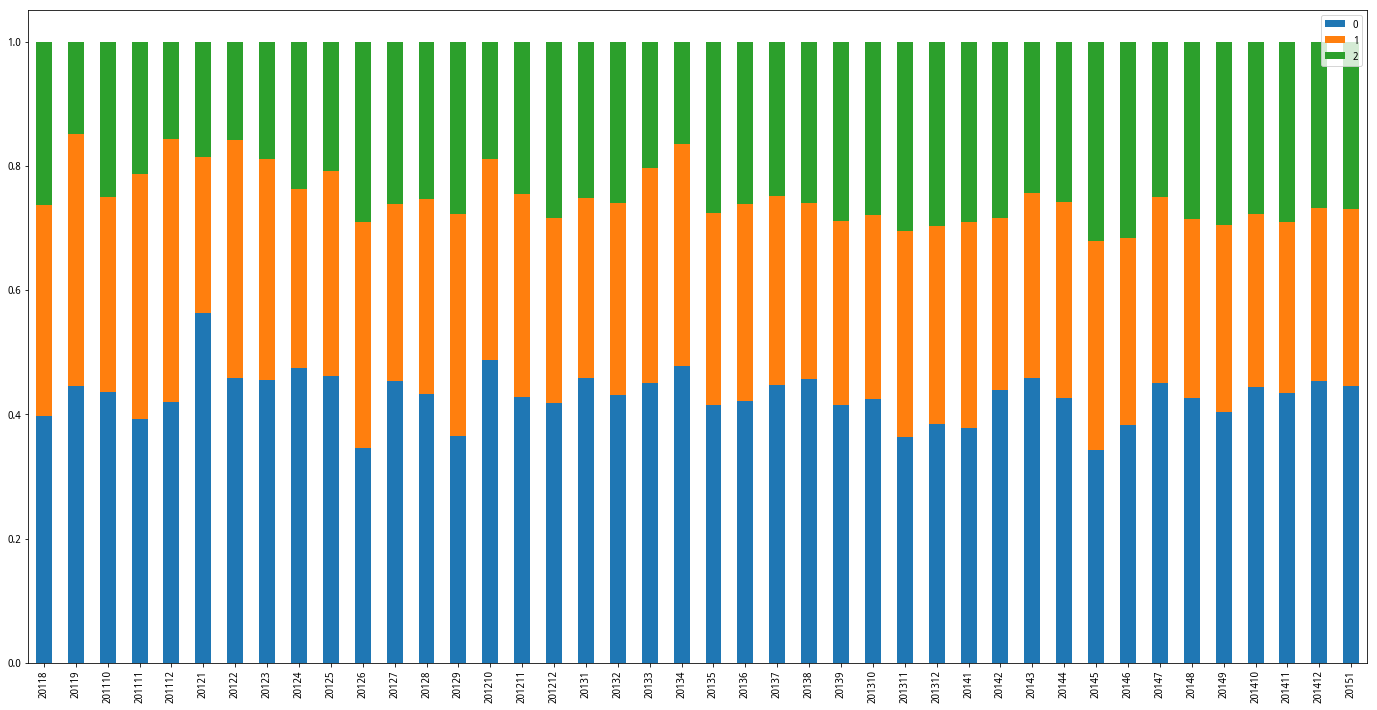

In [13]:
bar_increase.plot(kind='bar', stacked=True, figsize = (24,12))

在四年的观察期中，涨幅偏离值达7%的证券在每月中不同板块所占比例没有明显的变化。

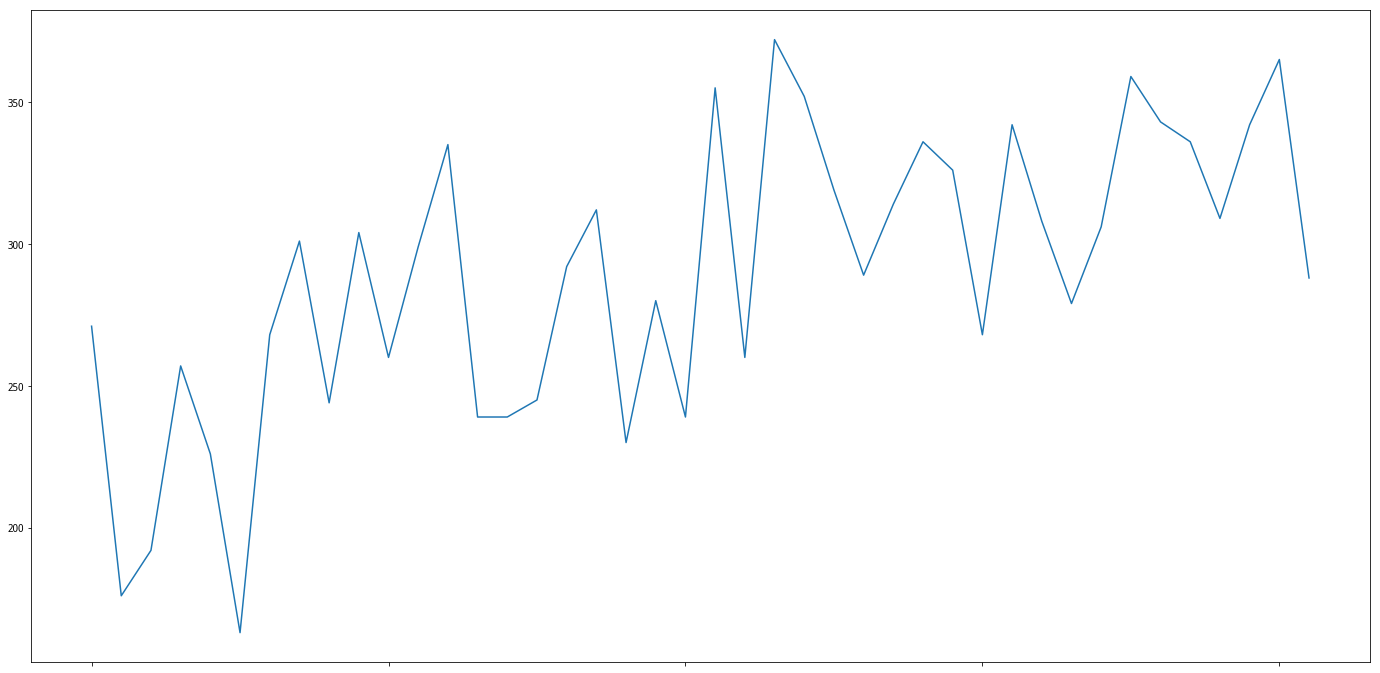

In [14]:
sum_increase.plot(figsize = (24,12))

在四年的观察期中，涨幅偏离值达7%的证券上榜案例数量呈震荡上升趋势。

In [9]:
industry_increase = industry_count(billboard_increase)

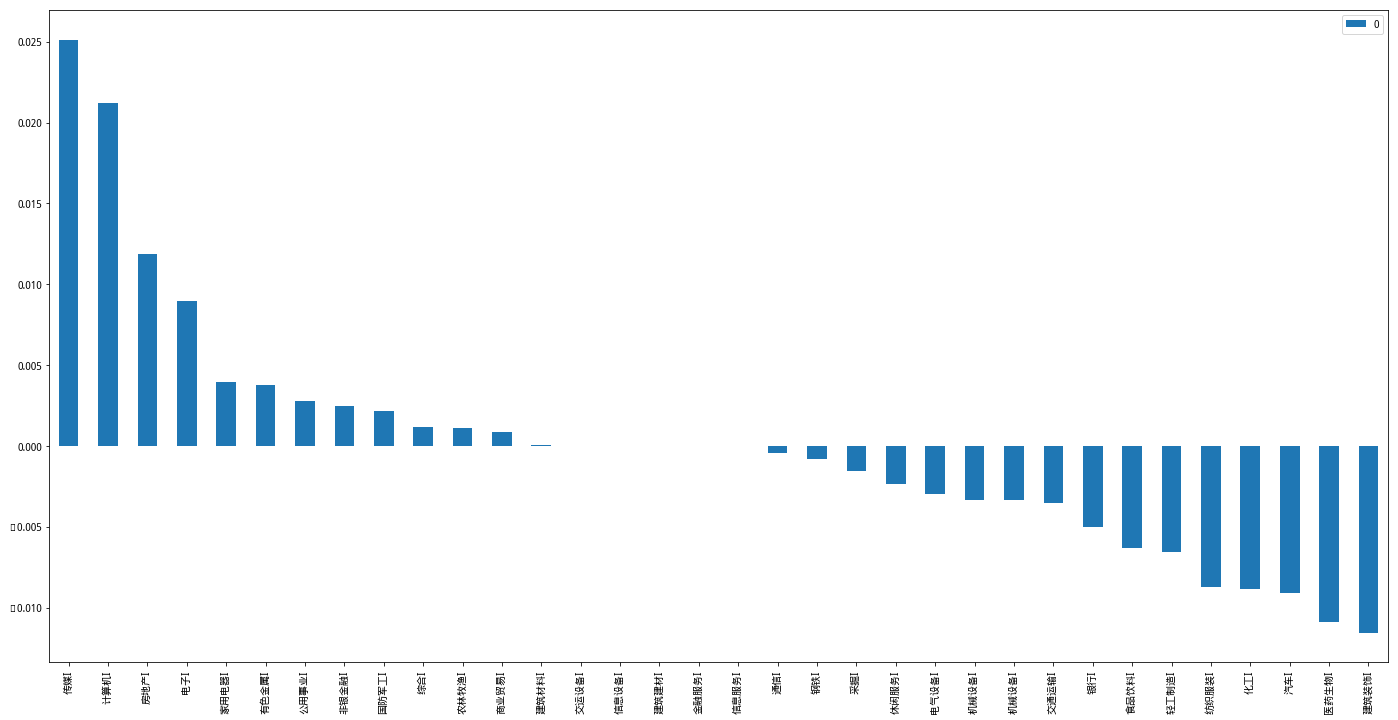

In [10]:
industry_plot(benchmark,industry_increase)

在四年的观察期中，涨幅偏离值达7%的证券在行业上并不存在太大的偏离，相对而言传媒与计算机行业较多而医药生物与建筑装饰行业较少。

## 跌幅偏离值达7%的证券

In [15]:
part_decrease = part_belonged(billboard_decrease)
monthly_part_decrease = monthly_part(part_decrease)
bar_decrease = monthly_part_decrease.loc[:2].T
sum_decrease = monthly_part_decrease.loc[3]

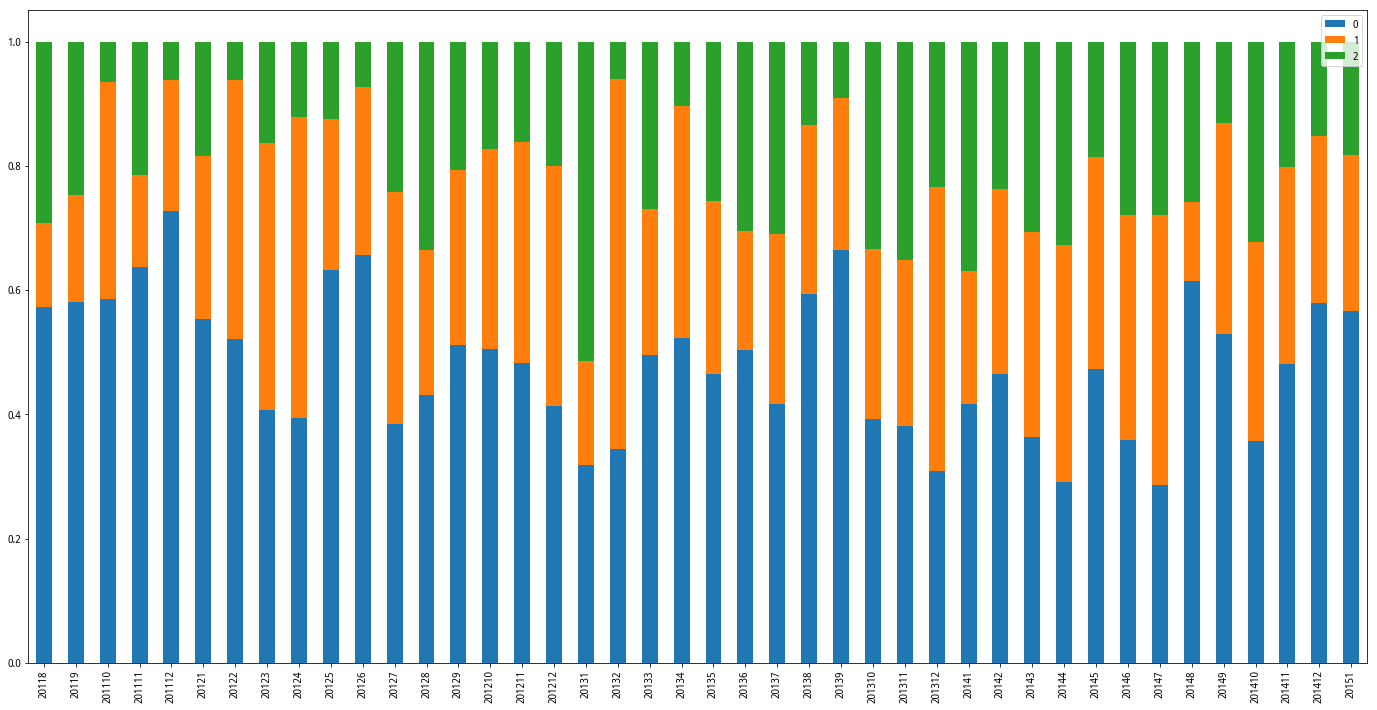

In [16]:
bar_decrease.plot(kind='bar', stacked=True, figsize = (24,12))

在四年的观察期中，跌幅偏离值达7%的证券在每月中不同板块所占比例没有明显的变化。

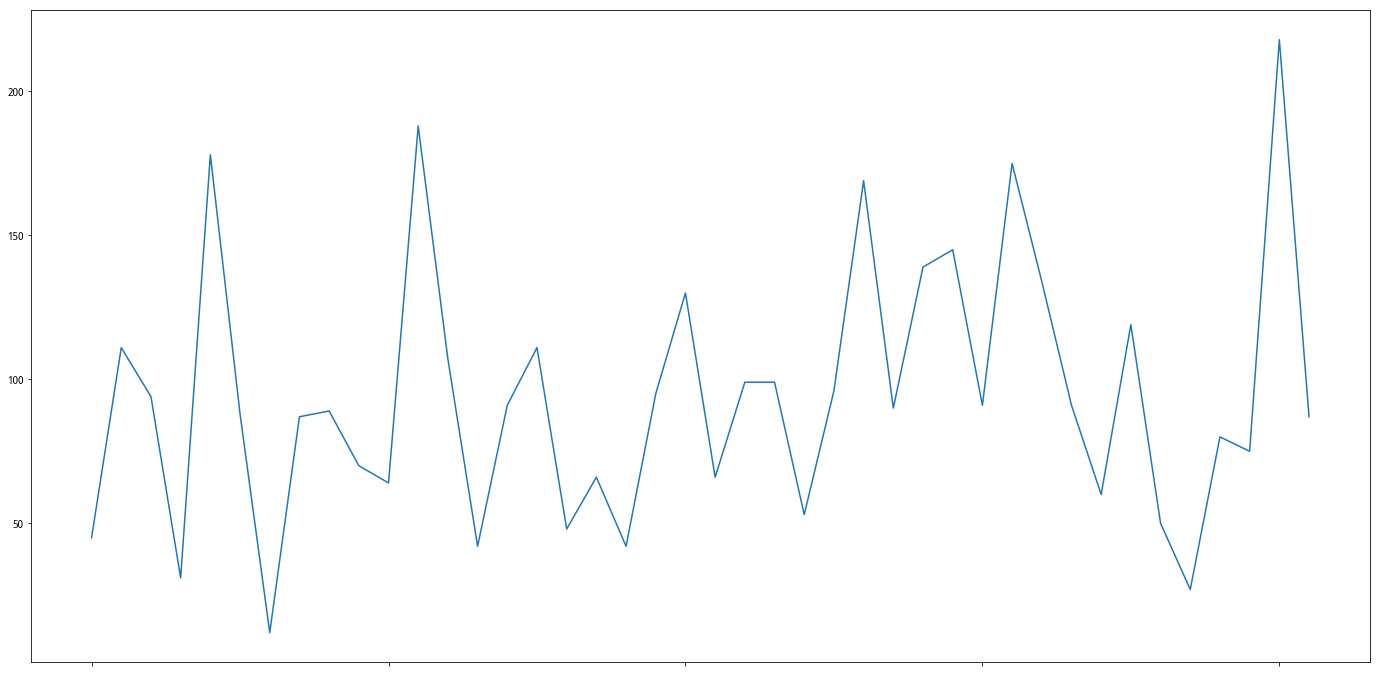

In [17]:
sum_decrease.plot(figsize = (24,12))

在四年的观察期中，跌幅偏离值达7%的证券上榜案例数量震荡程度较大，上升不明显。

In [11]:
industry_decrease = industry_count(billboard_decrease)

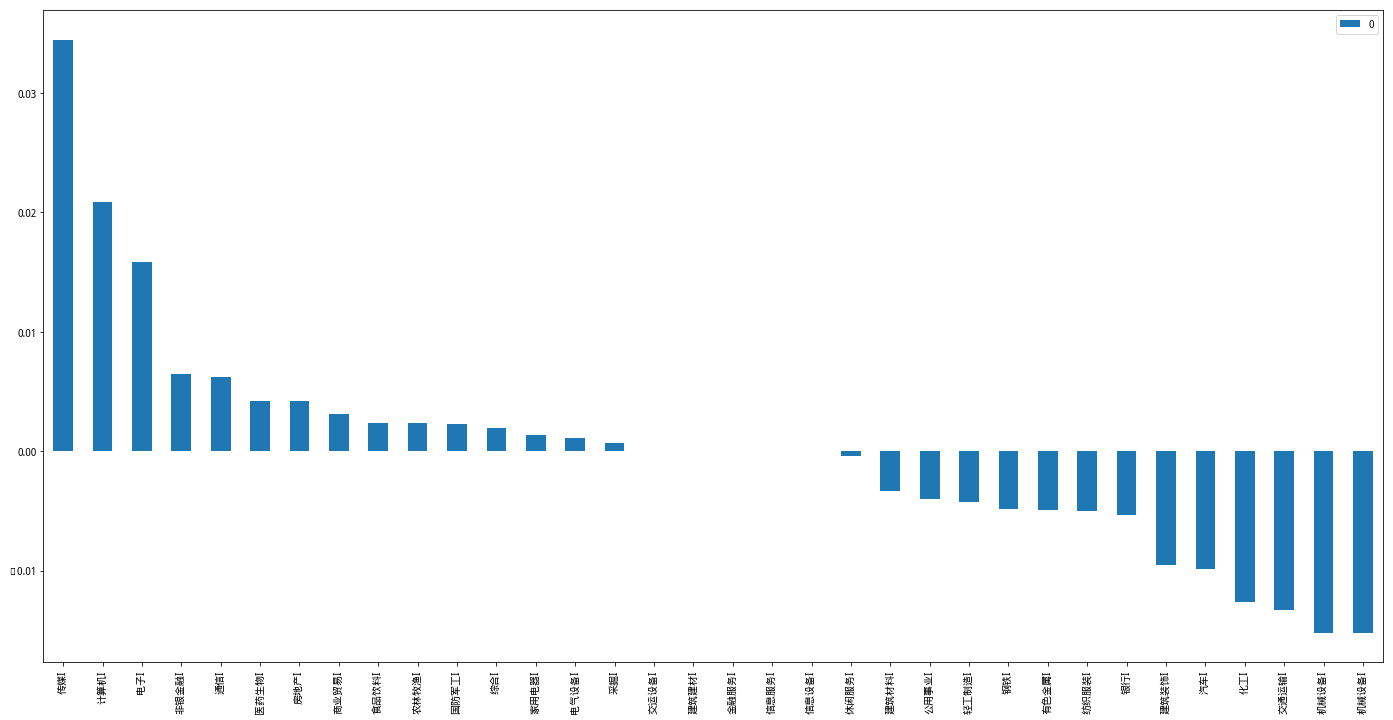

In [12]:
industry_plot(benchmark,industry_decrease)

在四年的观察期中，跌幅偏离值达7%的证券在行业上并不存在太大的偏离，相对而言传媒，计算机与电子行业较多而交通运输与机械设备行业较少。

## 日价格振幅达到15%的证券

In [18]:
part_amplitude = part_belonged(billboard_amplitude)
monthly_part_amplitude = monthly_part(part_amplitude)
bar_amplitude = monthly_part_amplitude.loc[:2].T
sum_amplitude = monthly_part_amplitude.loc[3]

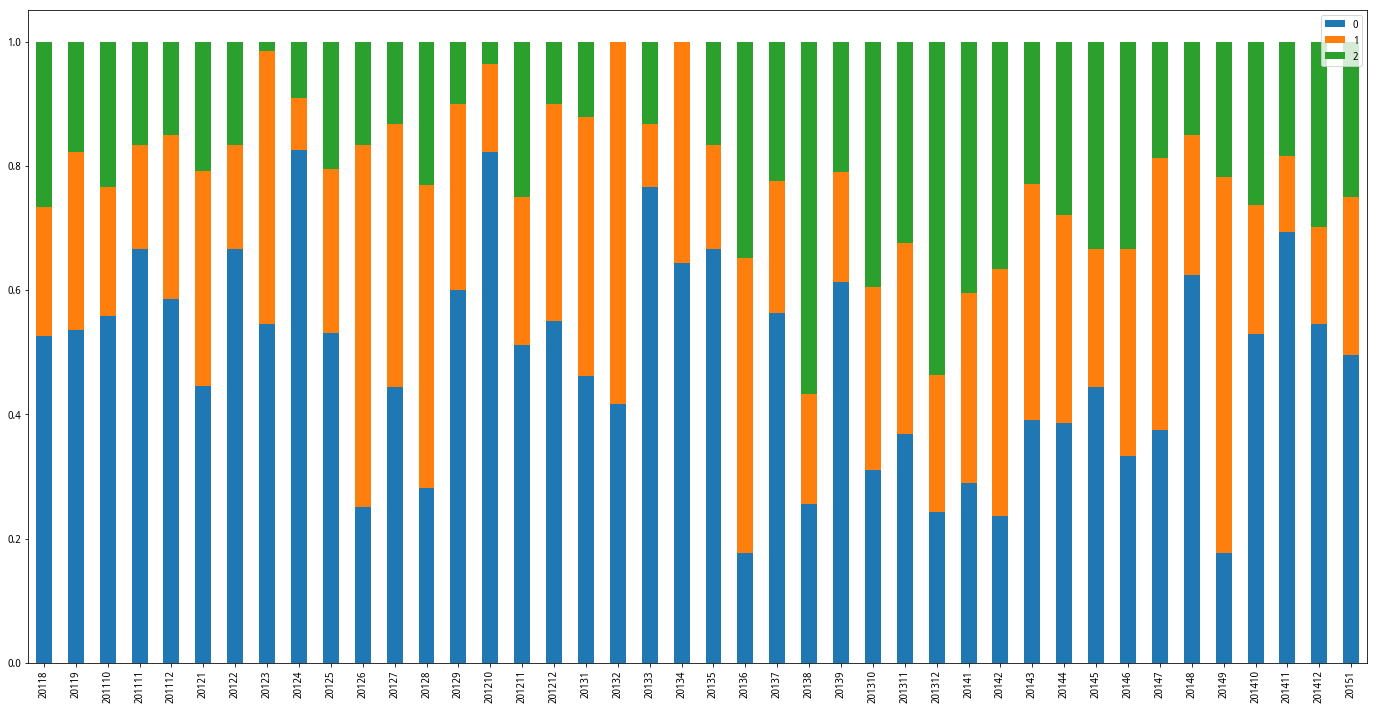

In [19]:
bar_amplitude.plot(kind='bar', stacked=True, figsize = (24,12))

在四年的观察期中，日价格振幅达到15%的证券在每月中不同板块所占比例没有明显的变化。

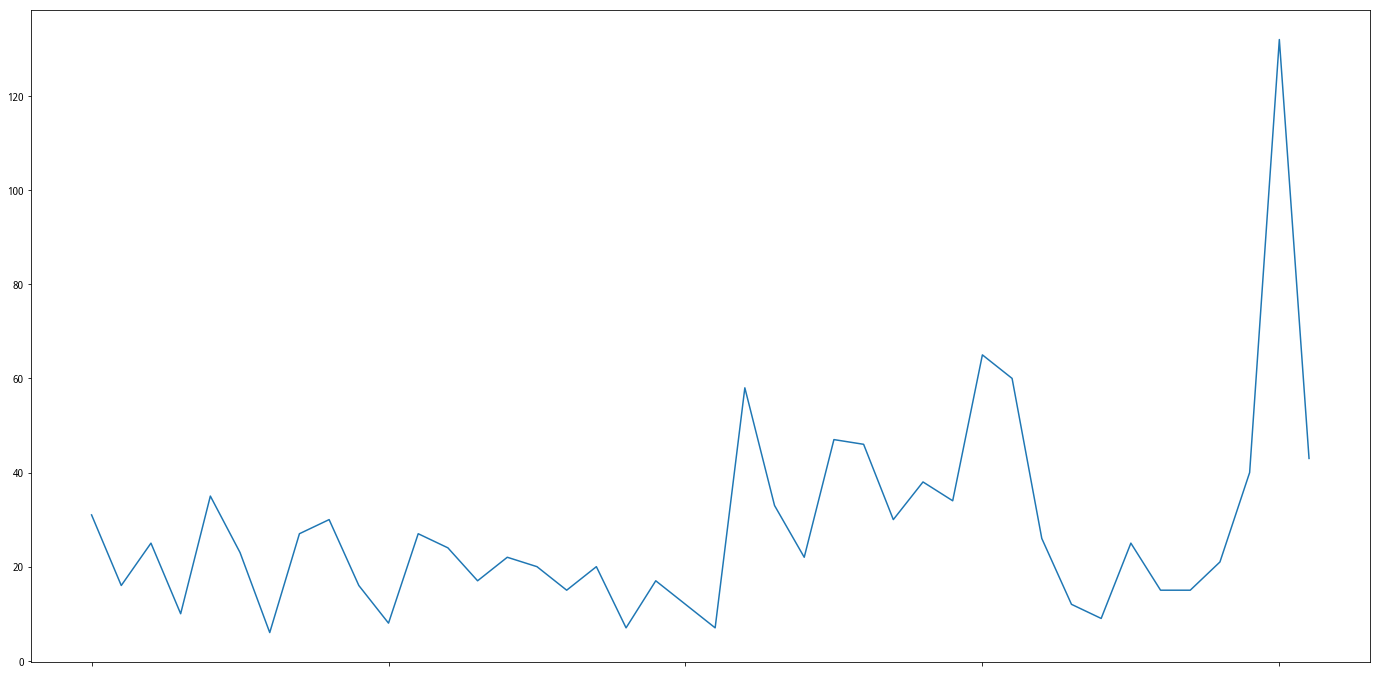

In [20]:
sum_amplitude.plot(figsize = (24,12))

在四年的观察期中，日价格振幅达到15%的证券上榜案例数量震荡程度较大，上升不明显。

In [13]:
industry_amplitude = industry_count(billboard_amplitude)

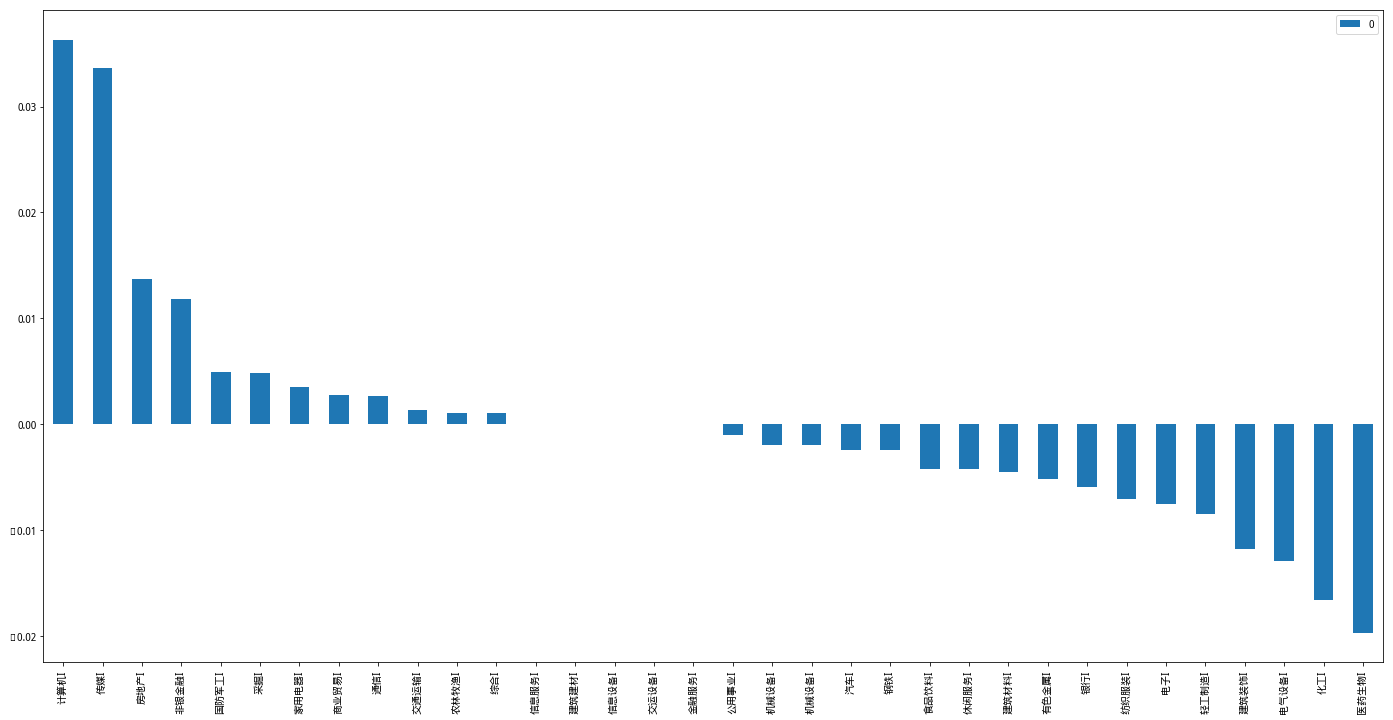

In [14]:
industry_plot(benchmark,industry_amplitude)

在四年的观察期中，日价格振幅达到15%的证券在行业上并不存在太大的偏离，相对而言计算机与传媒行业较多而电气设备，化工与医药生物行业较少。

## 换手率达20%的证券

In [21]:
part_turnover = part_belonged(billboard_turnover)
monthly_part_turnover = monthly_part(part_turnover)
bar_turnover = monthly_part_turnover.loc[:2].T
sum_turnover = monthly_part_turnover.loc[3]

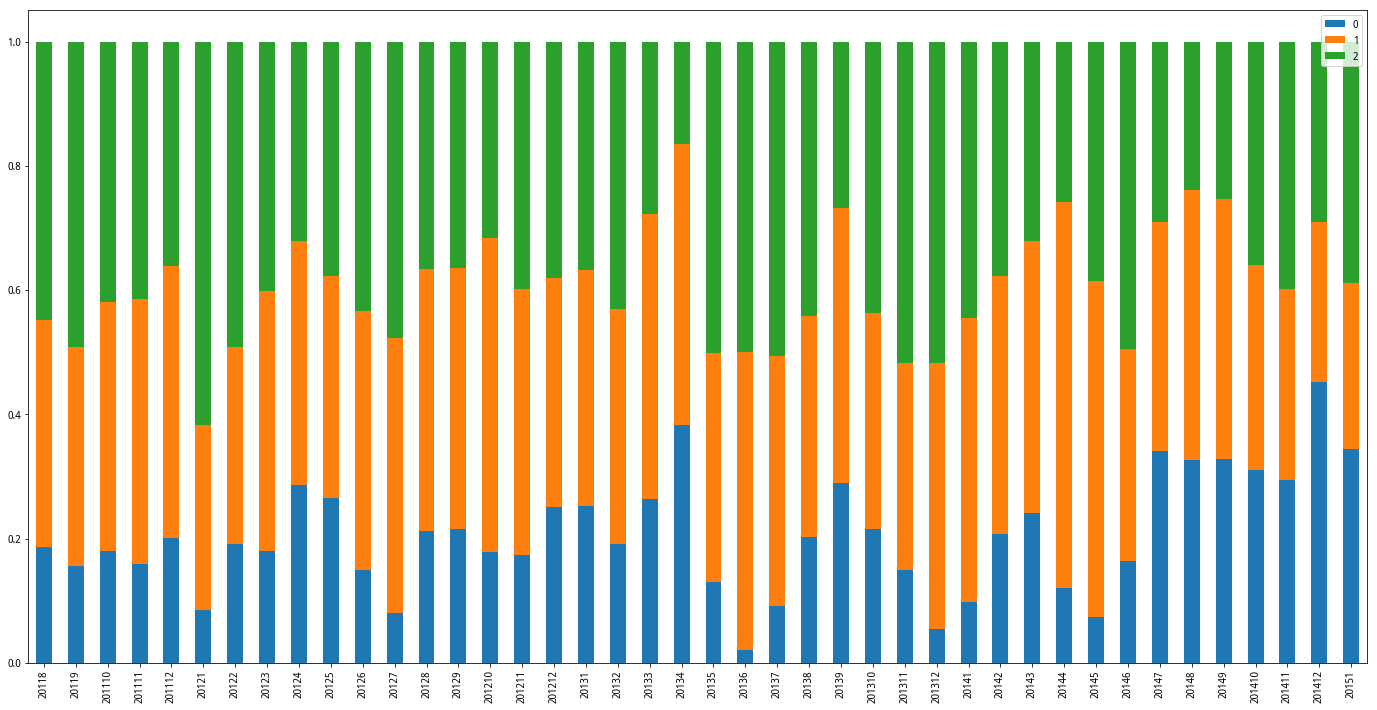

In [22]:
bar_turnover.plot(kind='bar', stacked=True, figsize = (24,12))

在四年的观察期中，换手率达20%的证券在每月中不同板块所占比例有趋于平均，且与前三者不同的是，其中中小板以及创业板股票所占比例较高而主板股票占比较低。

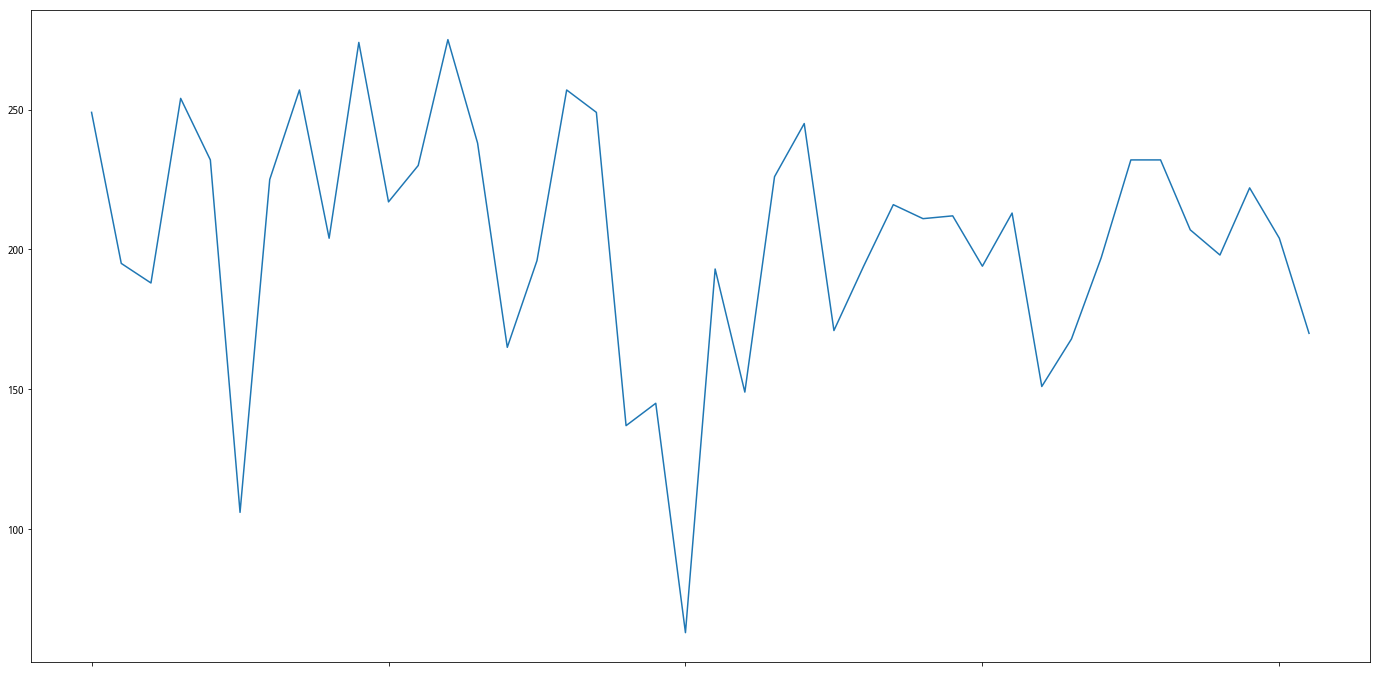

In [23]:
sum_turnover.plot(figsize = (24,12))

在四年的观察期中，换手率达20%的证券上榜案例数量震荡程度较大，且有下降趋势。

In [15]:
industry_turnover = industry_count(billboard_turnover)

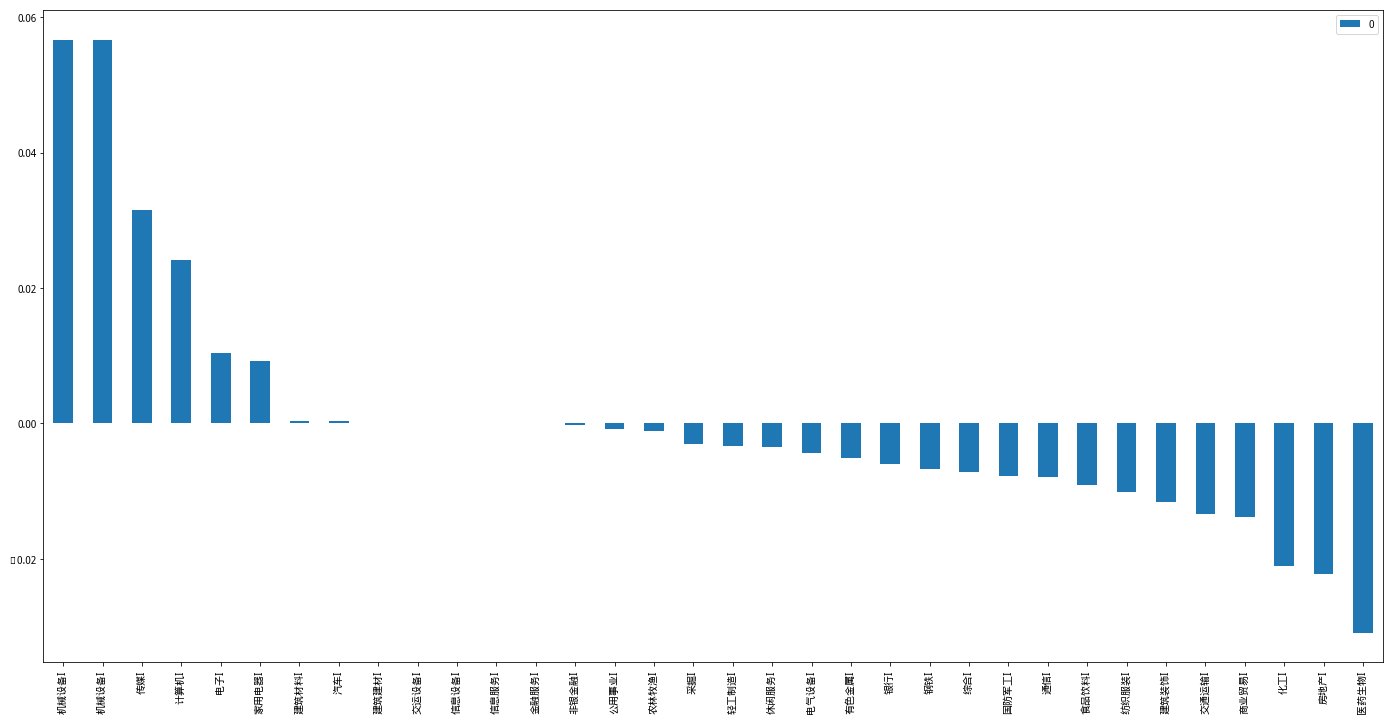

In [16]:
industry_plot(benchmark,industry_turnover)

在四年的观察期中，换手率达20%的证券在行业上并不存在太大的偏离，相对而言机械设备行业较多而化工，房地产与医药生物行业较少。

## 连续三个交易日内收盘价格涨幅偏离值累计达到20%的证券

In [24]:
part_increase_series = part_belonged(billboard_increase_series)
monthly_part_increase_series = monthly_part(part_increase_series)
bar_increase_series = monthly_part_increase_series.loc[:2].T
sum_increase_series = monthly_part_increase_series.loc[3]

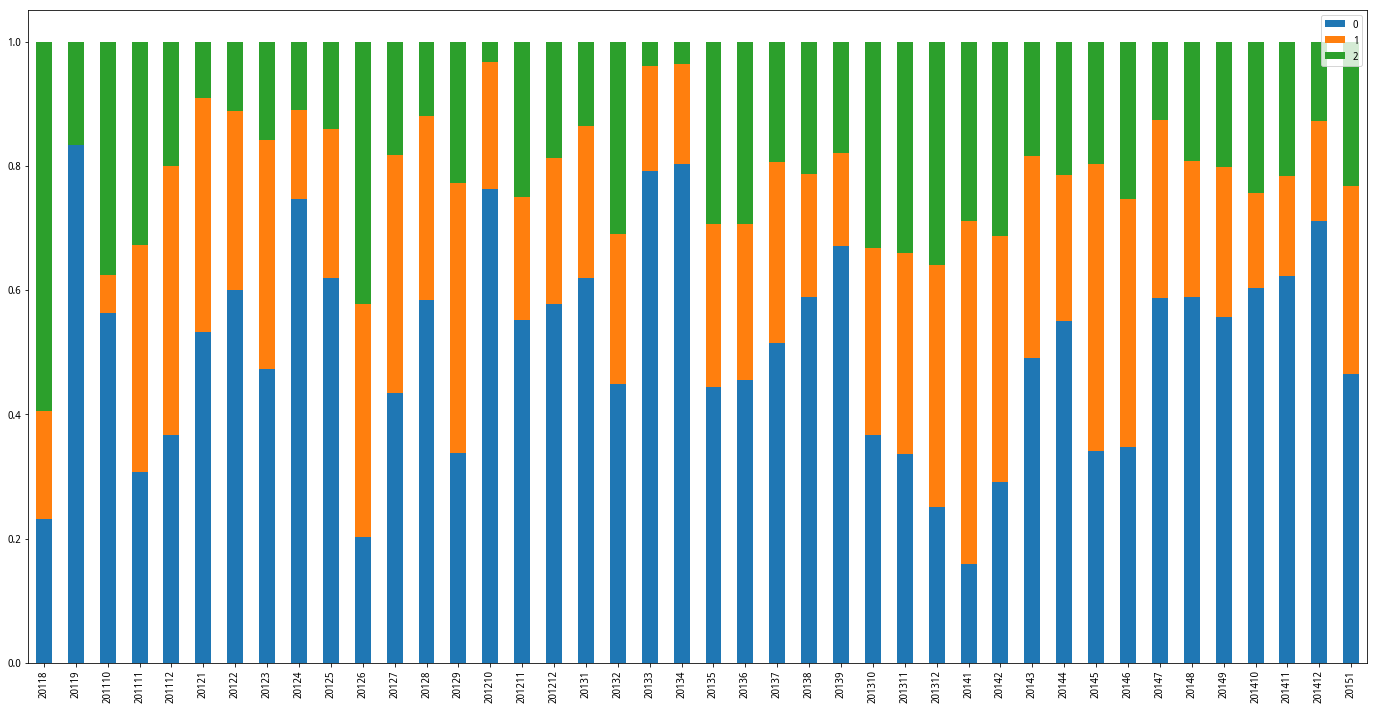

In [25]:
bar_increase_series.plot(kind='bar', stacked=True, figsize = (24,12))

在四年的观察期中，连续三个交易日内收盘价格涨幅偏离值累计达到20%的证券在每月中不同板块所占比例变化并无明显规律。

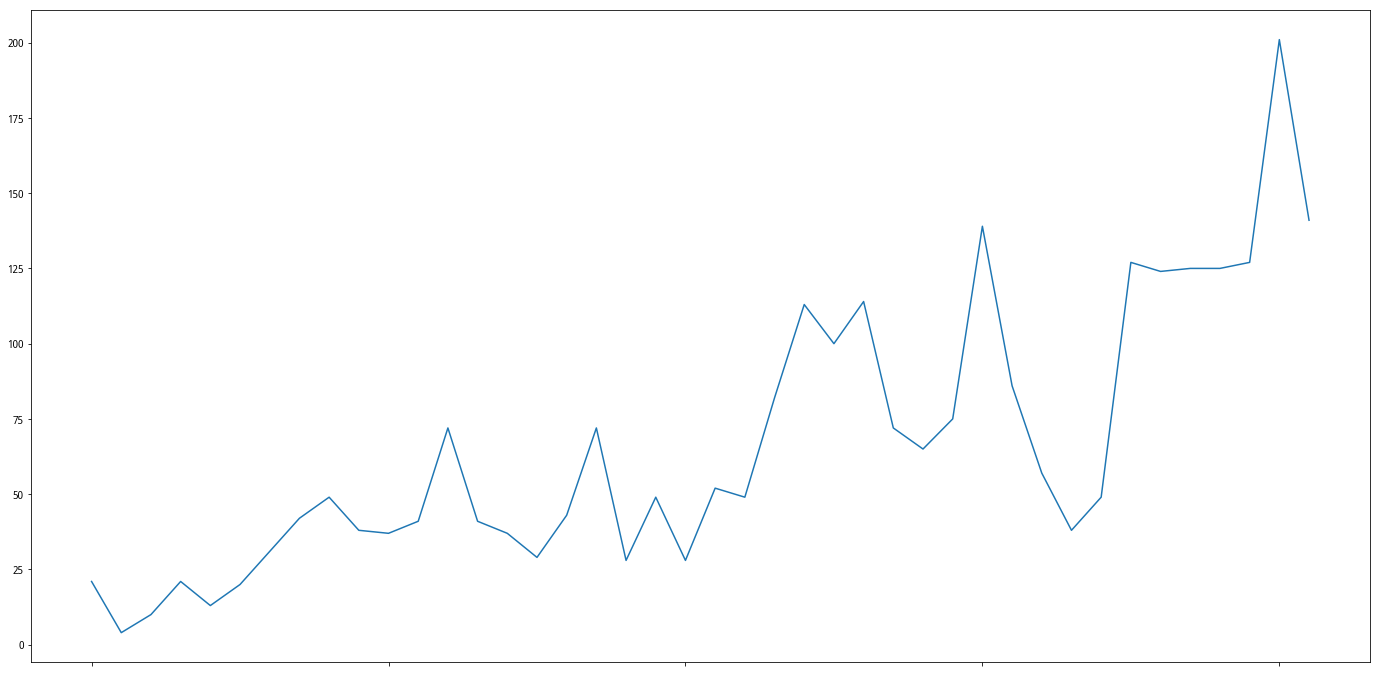

In [26]:
sum_increase_series.plot(figsize = (24,12))

在四年的观察期中，连续三个交易日内收盘价格涨幅偏离值累计达到20%的证券上榜案例数量呈明显上升趋势。

In [17]:
industry_increase_series = industry_count(billboard_increase_series)

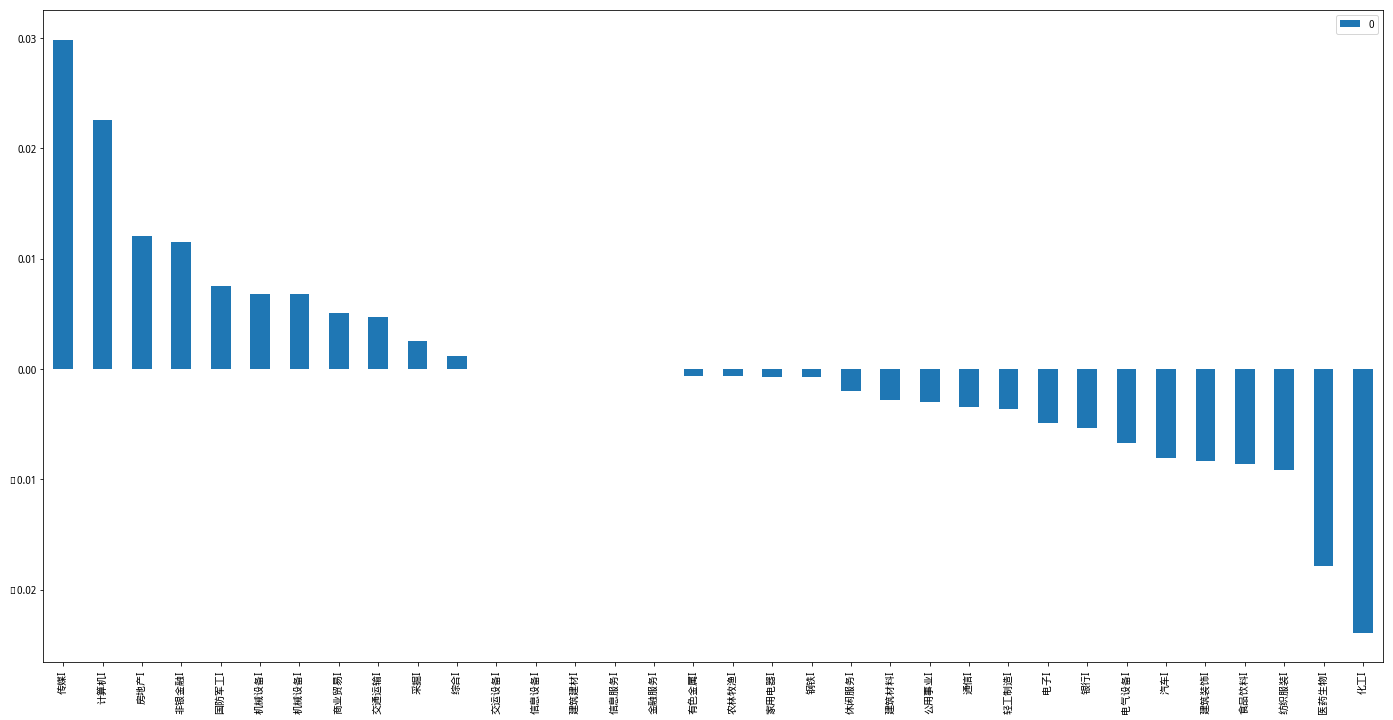

In [18]:
industry_plot(benchmark,industry_increase_series)

在四年的观察期中，连续三个交易日内收盘价格涨幅偏离值累计达到20%的证券在行业上并不存在太大的偏离，相对而言传媒与计算机行业较多而医药生物与化工行业较少。

## 连续三个交易日内收盘价格跌幅偏离值累计达到20%的证券

In [27]:
part_decrease_series = part_belonged(billboard_decrease_series)
monthly_part_decrease_series = monthly_part(part_decrease_series)
bar_decrease_series = monthly_part_decrease_series.loc[:2].T
sum_decrease_series = monthly_part_decrease_series.loc[3]

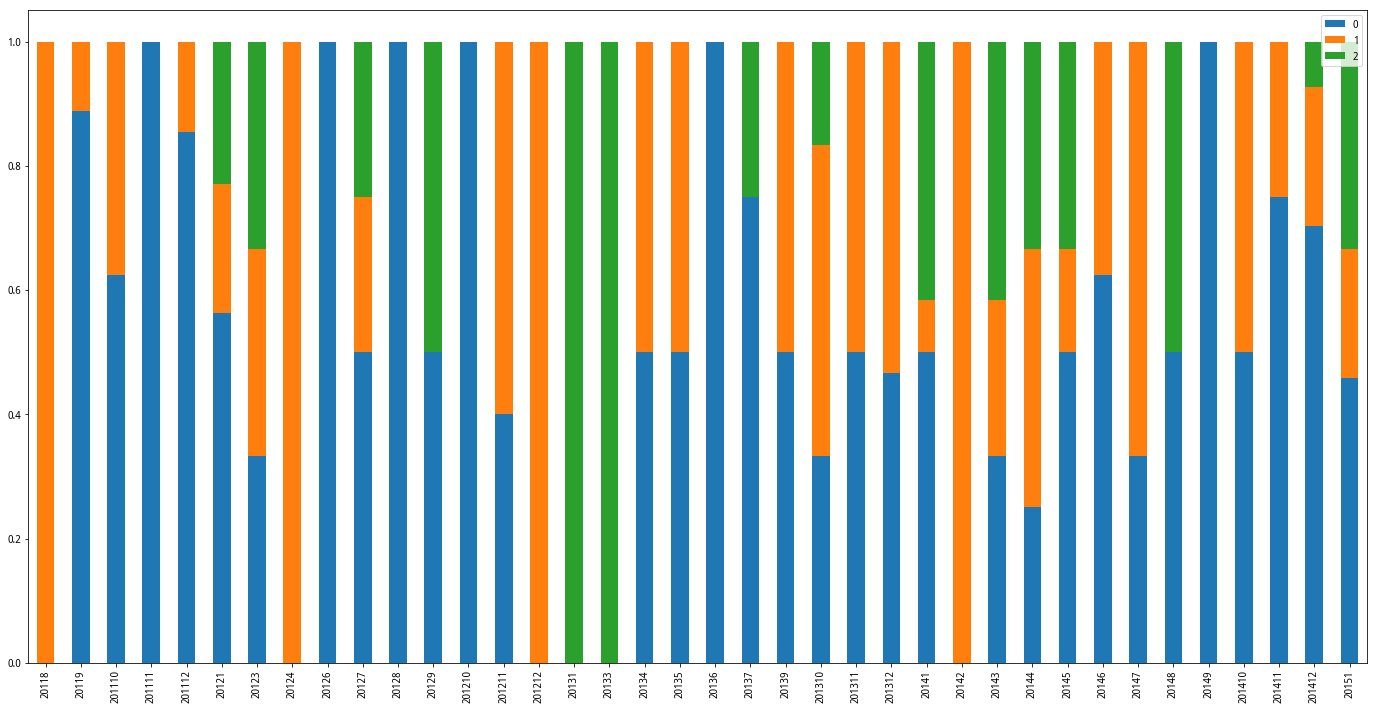

In [28]:
bar_decrease_series.plot(kind='bar', stacked=True, figsize = (24,12))

在四年的观察期中，连续三个交易日内收盘价格跌幅偏离值累计达到20%的证券在每月中不同板块所占比例变化并无明显规律，存在很多只有单个板块符合条件的月份。

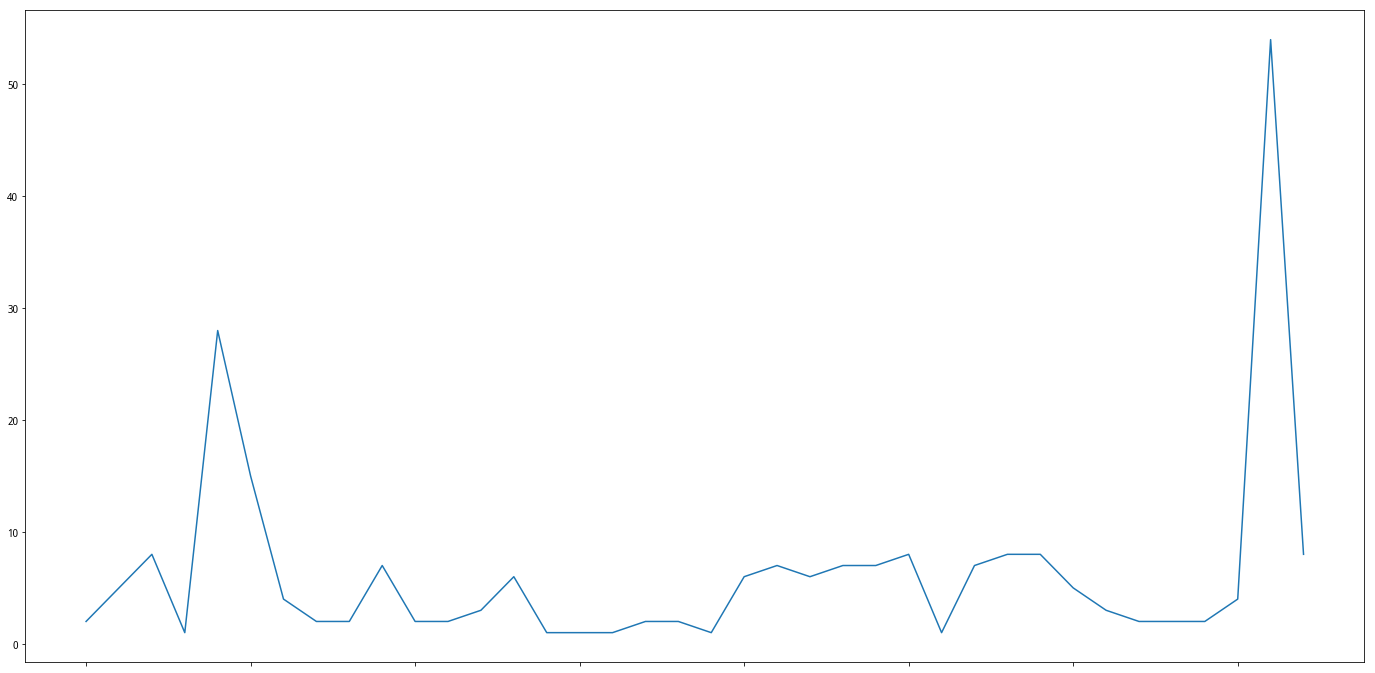

In [29]:
sum_decrease_series.plot(figsize = (24,12))

在四年的观察期中，连续三个交易日内收盘价格跌幅偏离值累计达到20%的证券上榜案例数量无明显增加，但与2014年及2011年底出现了井喷。

In [39]:
industry_decrease_series = industry_count(billboard_decrease_series)

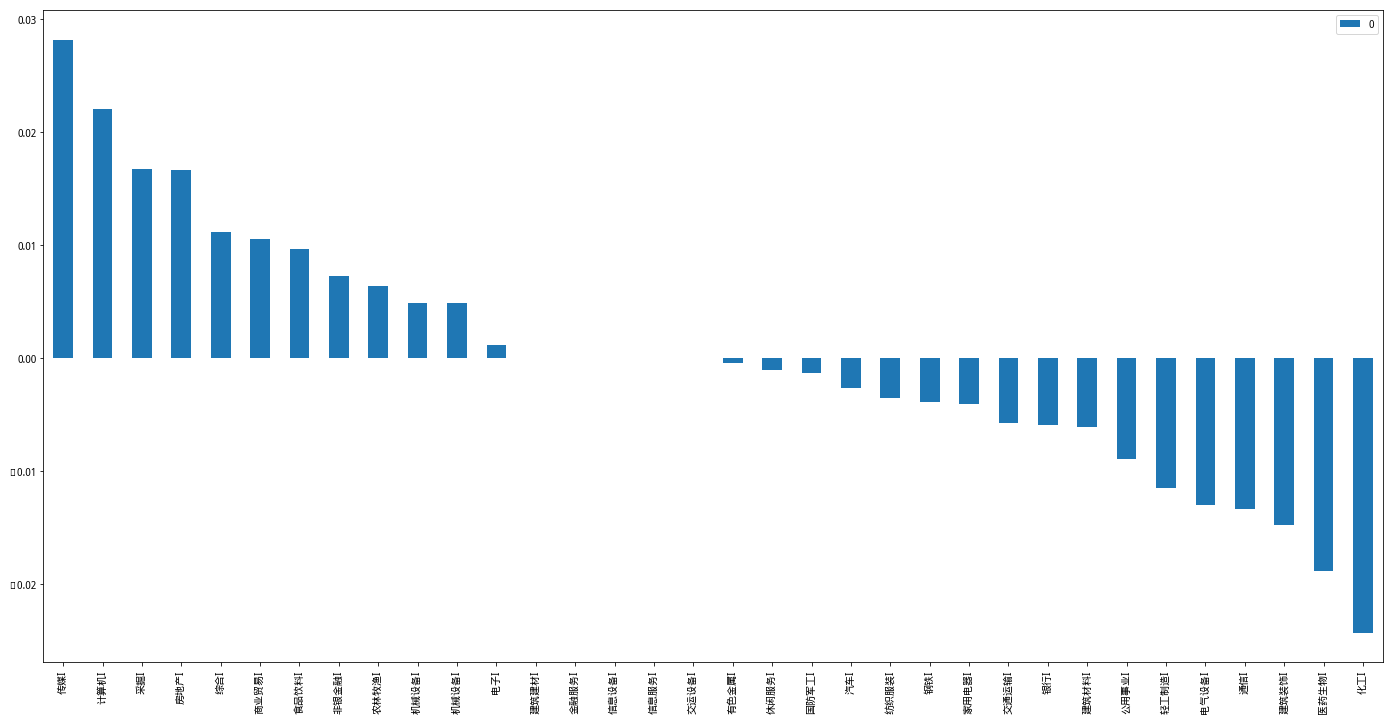

In [42]:
industry_plot(benchmark,industry_decrease_series)

在四年的观察期中，连续三个交易日内收盘价格幅偏离值累计达到20%的证券在行业上并不存在太大的偏离，相对而言传媒与计算机行业较多而建筑装饰，医药生物与化工行业较少。

# 收益分析 — 从披露原因的视角

## 涨幅偏离值达7%的证券

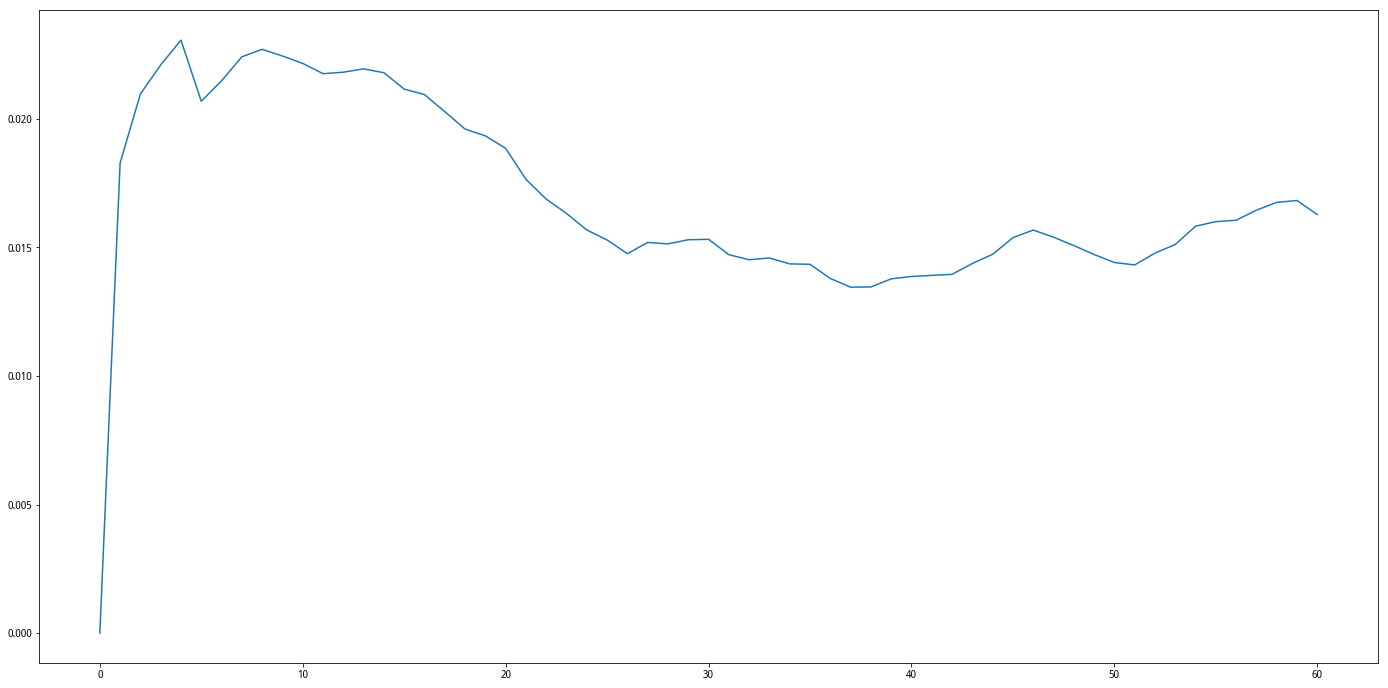

In [5]:
return_plot(billboard_increase)

对于涨幅偏离值达7%的证券组合，在上榜5天时达到了收益的峰值，约为2%，再之后出现了约0.5%的回撤。

## 跌幅偏离值达7%的证券

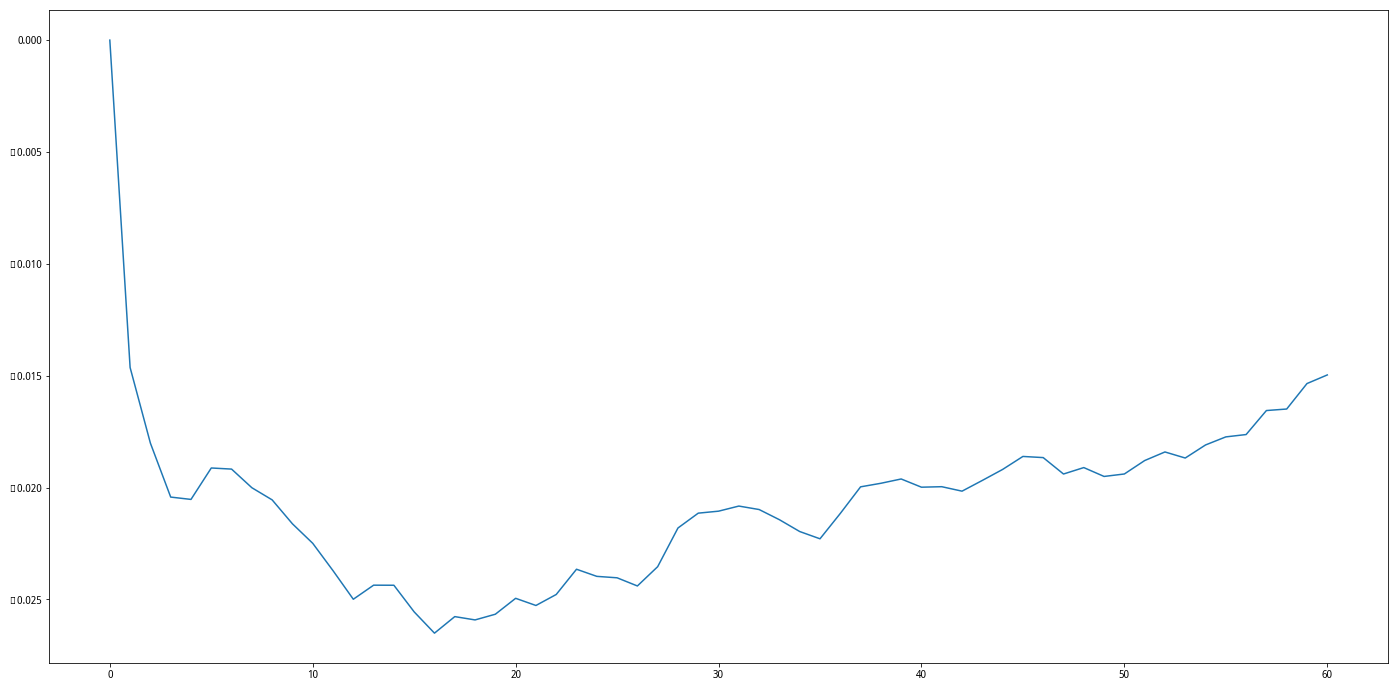

In [6]:
return_plot(billboard_decrease)

对于跌幅偏离值达7%的证券组合，在60天内出现了2.5%的收益回撤，在16天是达到了最低点，之后有约1%的回升。

## 日价格振幅达到15%的证券

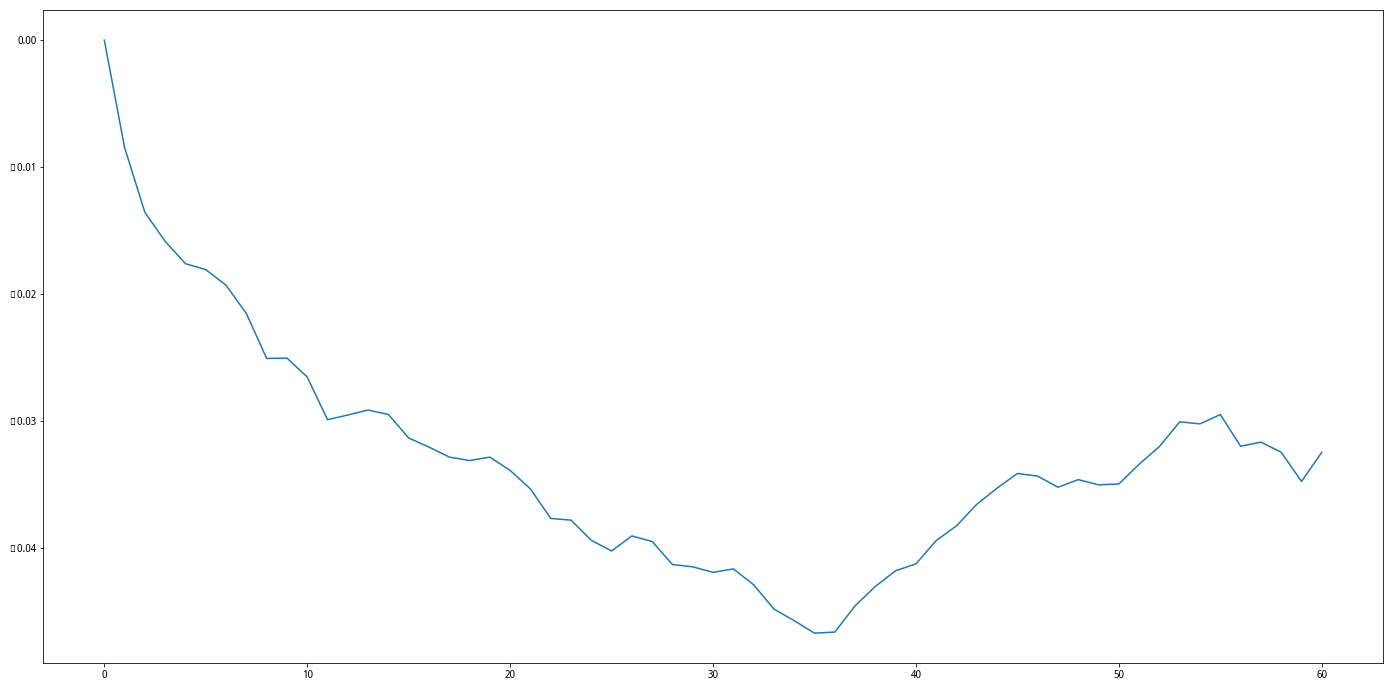

In [7]:
return_plot(billboard_amplitude)

对于日价格振幅达到15%的证券组合，在35天时出现了超过4%的回撤，60天内总体回撤在3%至4%之间。

## 换手率达20%的证券

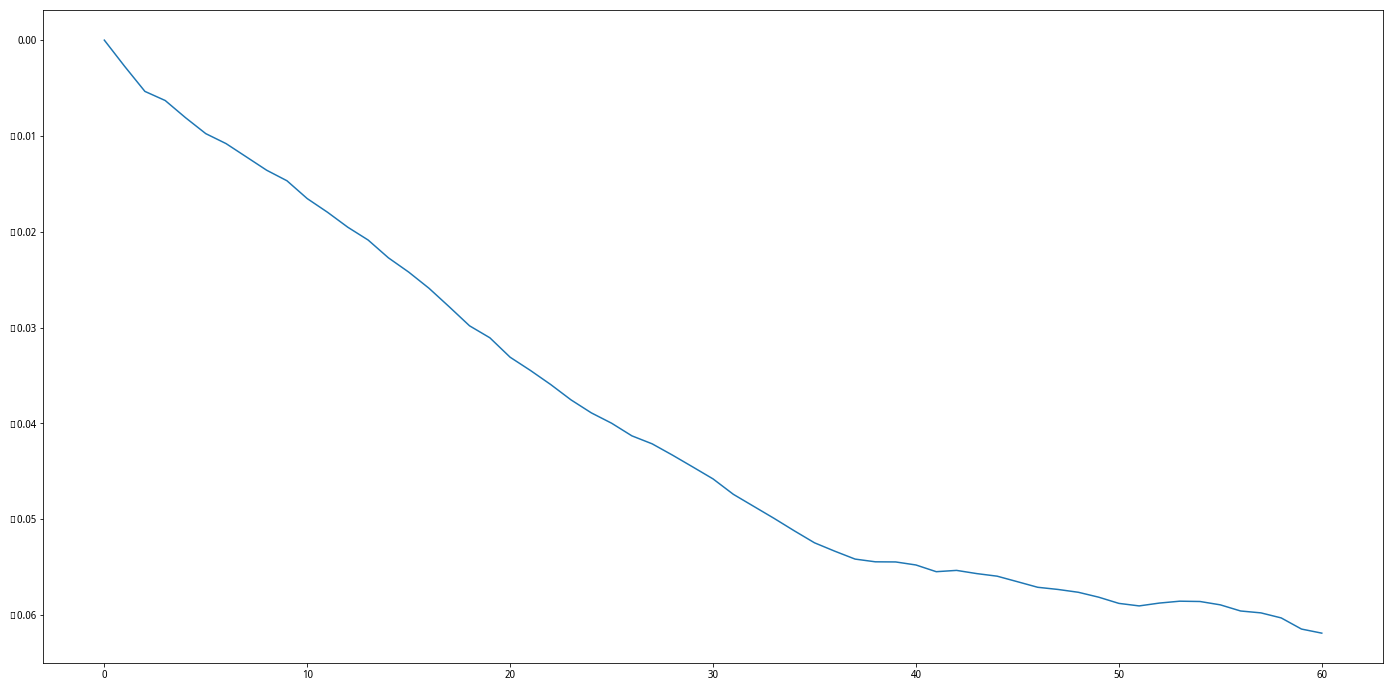

In [8]:
return_plot(billboard_turnover)

对于换手率达20%的证券组合，60天中出现了明显的6%回撤，体现了换手率指标在短期内为负向指标。

## 连续三个交易日内收盘价格涨幅偏离值累计达到20%的证券

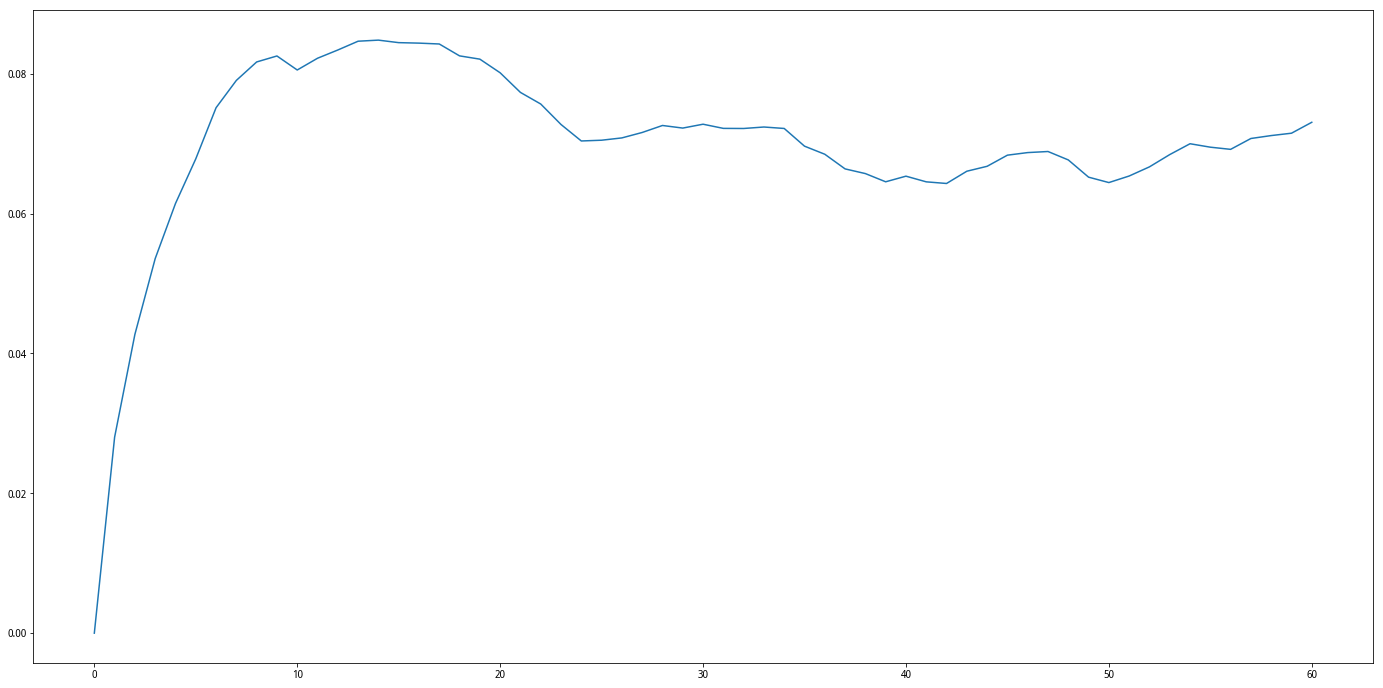

In [9]:
return_plot(billboard_increase_series)

对于连续三个交易日内收盘价格涨幅偏离值累计达到20%的证券组合，在15天左右的时候达到了收益高点，约为8%，随后出现了1%左右的回撤。

## 连续三个交易日内收盘价格跌幅偏离值累计达到20%的证券

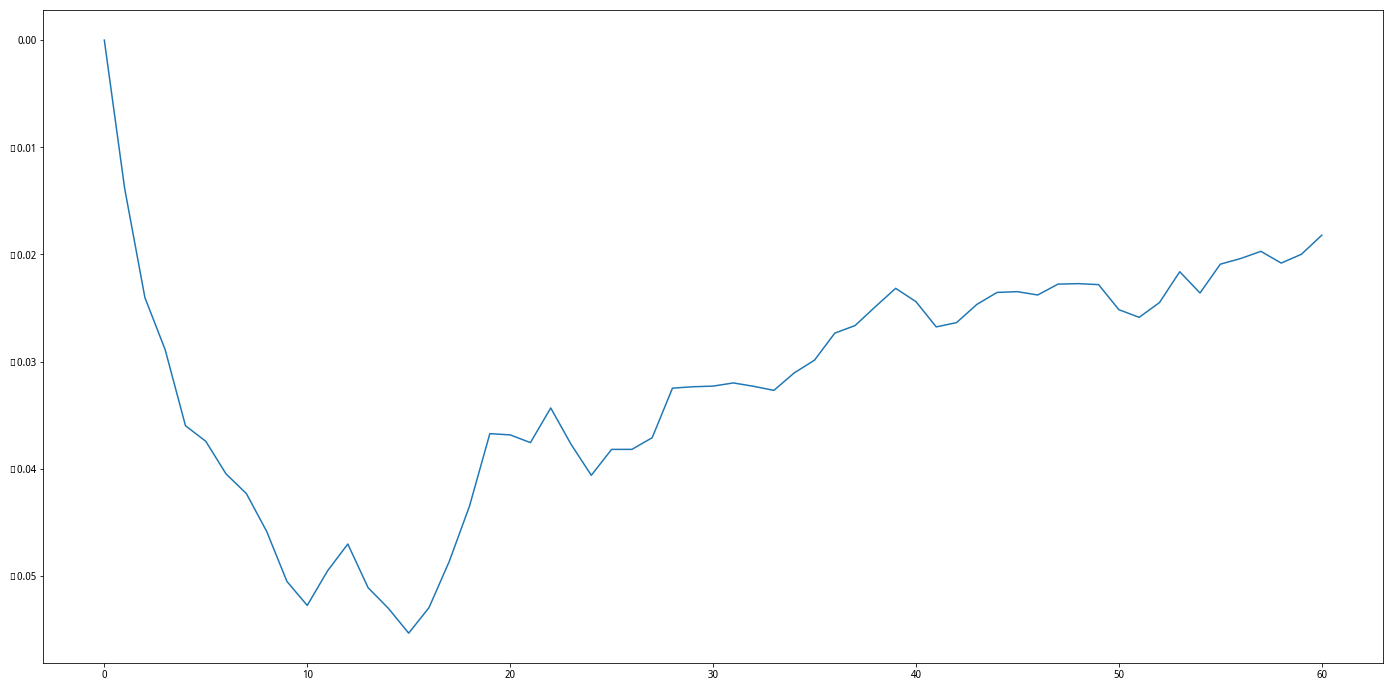

In [10]:
return_plot(billboard_decrease_series)

对于连续三个交易日内收盘价格跌幅偏离值累计达到20%的证券组合，在15天左右出现了超过5%的最大回撤，虽有有所回升。

# 风格观察 — 机构专用席位

In [30]:
part_org = part_belonged(billboard_org)
monthly_part_org = monthly_part(part_org)
bar_org = monthly_part_org.loc[:2].T
sum_org = monthly_part_org.loc[3]

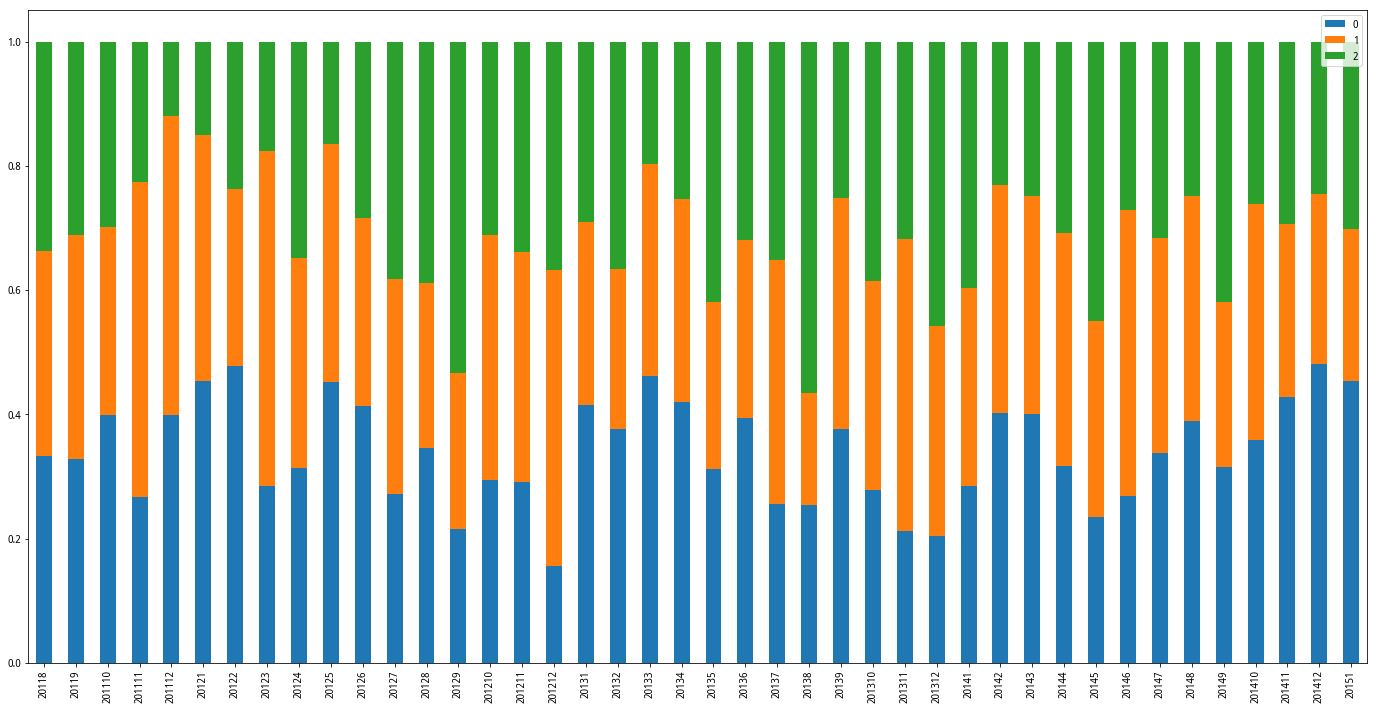

In [31]:
bar_org.plot(kind='bar', stacked=True, figsize = (24,12))

在行业分布上，机构买入的股票在板块分布上并没有明显的变化趋势，且板块分布较为平均，主板略多。

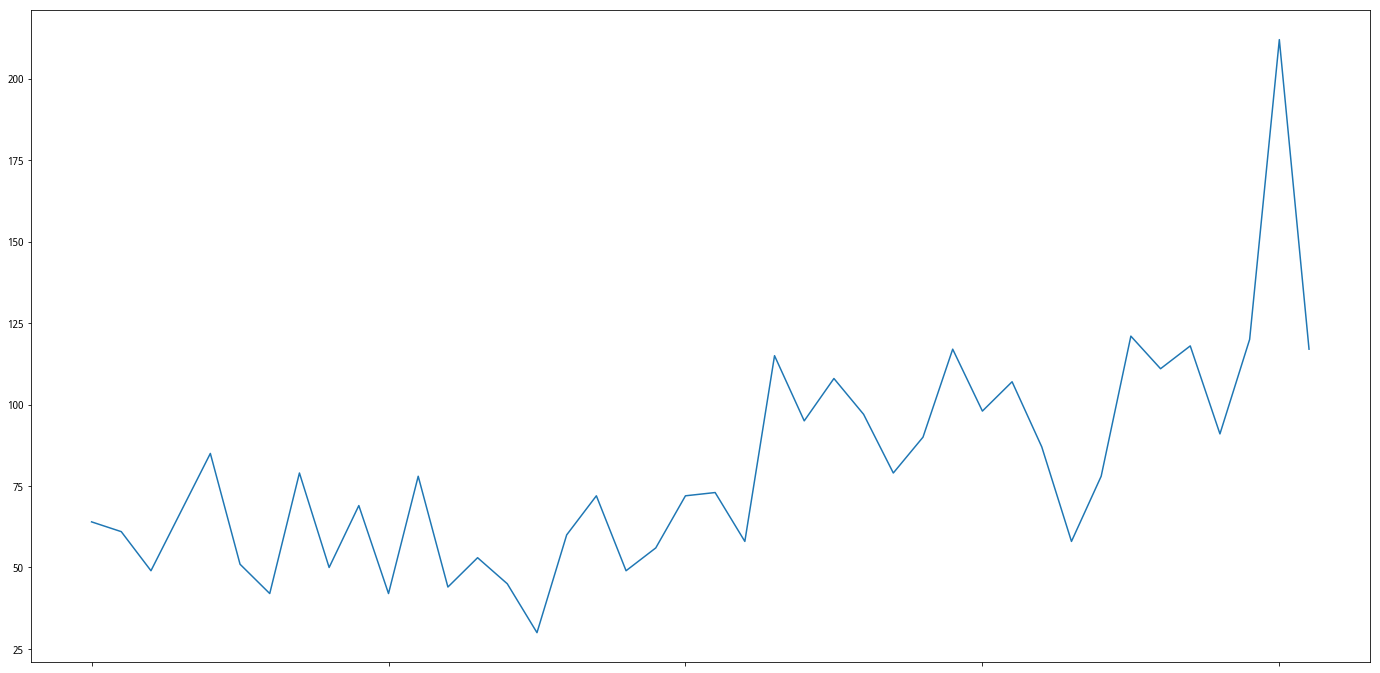

In [32]:
sum_org.plot(figsize = (24,12))

在绝对数量上，机构席位的出现次数呈上升趋势，且于2014年底出现了井喷。

In [24]:
industry_org = industry_count(billboard_org)

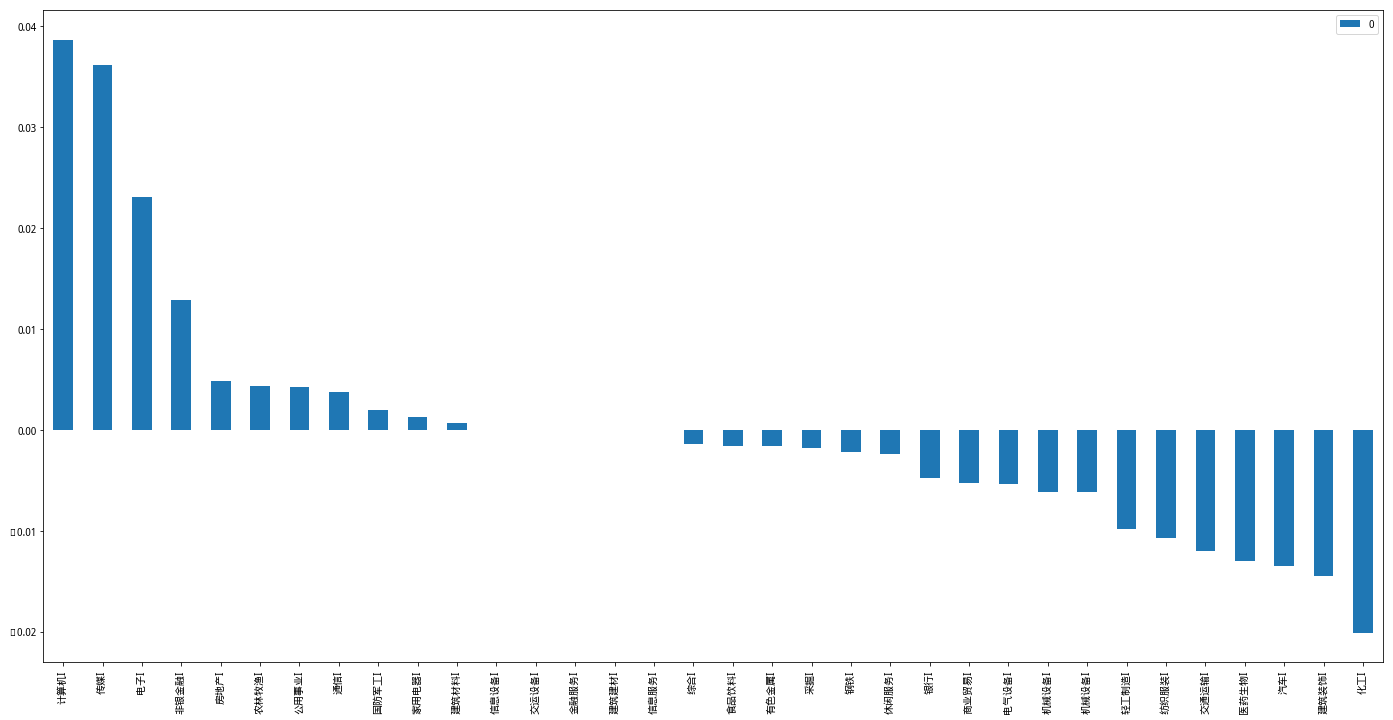

In [25]:
industry_plot(benchmark,industry_org)

机构买入席位在行业的分布上同样没有明显的差异，相对地，在计算机，传媒，电子行业上略多而汽车，化工，建筑装饰行业略少。

# 收益分析 — 机构专用席位

# “机构专用”席位的绝对数量

In [52]:
count_mean_price_df = count_mean_price(billboard_buy,[0,1,2])

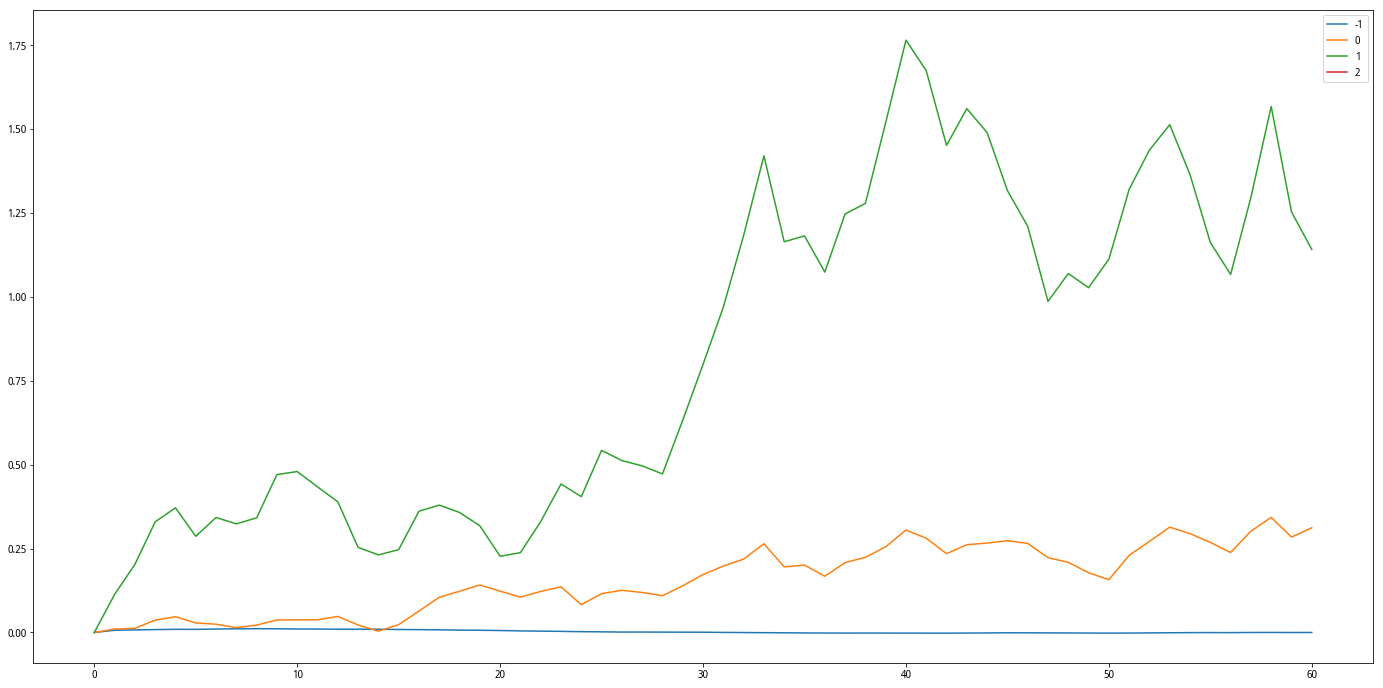

In [53]:
count_mean_price_df.plot(figsize = (24,12))

从图中我们可以看出，有机构参与买入的组合在60天内相对于指数有一定的超额收益，同时，当机构席位增加为2席时，超额收益的数值很大。

# “机构专用”席位的总买入金额与个股总成交金额的占比

In [7]:
rate_mean_price_df = rate_mean_price(billboard_buy,[0,0.1])

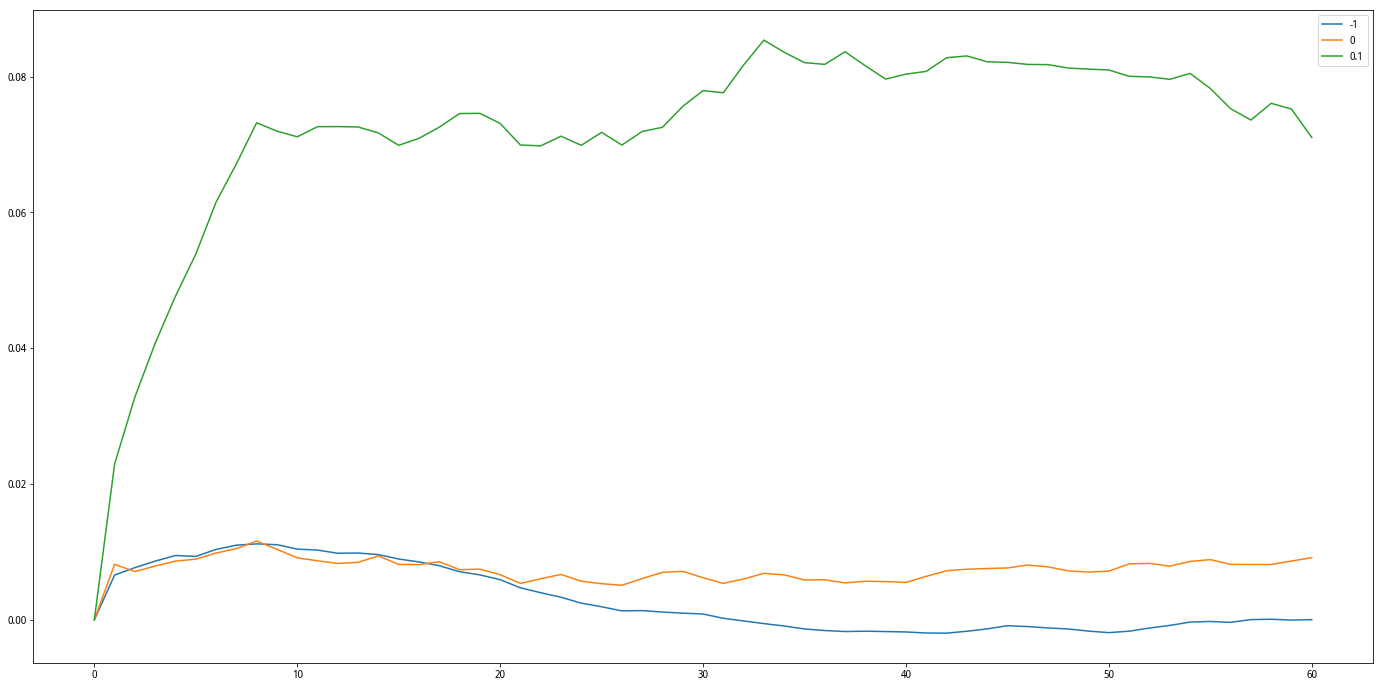

In [8]:
rate_mean_price_df.plot(figsize = (24,12))

从图中可以看出，60天内，同样地机构买入的组合存在一定的超额收益，在买入金额占成交总金额10%以上时，存在明显的超额收益约为8%，且在前10天增长最为明显。

# 总结

本文对国泰君安研报《探索交易公开信息之市场观察篇》进行了复现，对不同因子的超额收益进行了分析，初步得到了以下结论：

（1）出现在龙虎榜上的股票披露原因为涨幅偏离值达7%的证券以及连续三个交易日内收盘价格涨幅偏离值累计达到20%的证券在未来的60天内超额期望收益均为正。其余的四种原因相对指数的超额收益均为负。

（2）出现龙虎榜上的股票在有机构进行买入时一般可以获得不同程度的超额收益，其中机构专用席位越多，超额收益越高，“机构专用”席位的总买入金额与个股总成交金额的占比越高，超额收益越高。